<h1><center>DSA 4212: Year 2022</center></h1>
<h3><center> Assignment 1 (Deadline: Sunday 27th March at 23:59) </center></h3>
<h4><center> Group Number: 03 </center></h4>
<h4><center> Group Member 1: Li Zhuoran, A0194510L </center></h4>
<h4><center> Group Member 2: Pan Yuting, A0201267N </center></h4>
<h4><center> Group Member 3: Zhang Simian, A0204709H </center></h4>
<h4><center> Group Member 4: Zhong Zhaoping, A0194519U </center></h4>

**Remark:** as described below, each group has to submit two documents on lumiNUS: 
1. a jupyter notebook with your code  
2. a pdf report explaining your approaches and conclusions.
3. you can have a look at `https://www.overleaf.com/read/xmvqgpsdqwyx` if you would like to use Overleaf and Latex to rapidly produce a neat report. You can use your NUS email to create an Overleaf account.

**File naming convention:**
1. the Jupyter notebook needs to be named `assignment_1_XX.ipynb`. For example, group number 3 needs to name its jupyter notebook as `assignment_1_03.ipynb`.
1. the pdf report needs to be named `assignment_1_XX.pdf`. For example, group number 3 needs to name its pdf report as `assignment_1_03.pdf`.



**To load data on Google Colab**:
1. Upload the data onto your Google Drive
2. Run the first cell to log in your Google account and mount on your Google Drive
3. Change *path_csv* and *path* accordingly

In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    print(path_to_file)
    # move to Google Drive directory
    os.chdir(path_to_file)
    !pwd

In [2]:
# Google Colab import data: Much Faster to unzip files

!unzip "/content/gdrive/My Drive/DSA4212/datasets/img_celeba_small.zip" -d "/content"

unzip:  cannot find or open /content/gdrive/My Drive/DSA4212/datasets/img_celeba_small.zip, /content/gdrive/My Drive/DSA4212/datasets/img_celeba_small.zip.zip or /content/gdrive/My Drive/DSA4212/datasets/img_celeba_small.zip.ZIP.


In [2]:
%matplotlib inline
from jax.config import config
config.update("jax_enable_x64", True) # for higher accuracy
config.update("jax_platform_name", 'cpu') # use cpu if needed

import jax
import jax.numpy as jnp
import numpy as np

import pylab as plt
import imageio
import os
import numpy as onp
# to install scikit-image: !pip install scikit-image
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd
import time

import dlib
import cv2
import math

In [4]:
#load attributes csv file
path_csv  = ".." # Local Path (Change Here)
# path_csv  = '/content/gdrive/My Drive/DSA4212/datasets' # Google Drive
attribute = pd.read_csv(os.path.join(path_csv, "celeba.csv"))


In [5]:
#let us list all the files in the image directory
path =  "../img_celeba_small"# Local Path (Change Here)
# path = "/content/img_celeba_small" # Google Drive
all_img = [f for f in os.listdir(path) 
                 if os.path.isfile(os.path.join(path, f)) 
                 and f.endswith(".jpg")]

# sort the images by alphabetical order 
# !!!! VERY IMPORTANT in order to be consistent with the labels contained in celeba.csv !!!!
all_img.sort()
nb_img = len(all_img)
print("Number of images:", nb_img)

#let us keep only the relevant attributes
attribute = attribute[:20000]

Number of images: 20000


In [7]:
import wget
url = "https://raw.githubusercontent.com/sightmachine/SimpleCV/master/SimpleCV/Features/HaarCascades/"
facial_parts = ['face', 'eye', 'mouth', 'nose']
for p in facial_parts:
    p_file = p + '.xml'
    p_url = url + p_file
    wget.download(p_url)

100% [..........................................................................] 1585210 / 1585210

## Common Utility Functions

In [7]:
# Image Loader

# #let us load the first 500 images
# n_img = 500
# img_array = onp.zeros((n_img, 100,100))
# for k in range(n_img):
#     im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
#     im = resize(im, (100,100) )
#     im = onp.mean(im, axis=2) # average the last channel
#     img_array[k,:,:] = im
    
def image_loader(indices, res, grey=False,contrast = None, verbose = 0):
    """
    Load Images

    args:
    indices: indices of the image to be loaded
    res: resolution of the image, an iterable of size 2
    grey: boolean to decide whether loaded images are grey scaled. Default is False (color images)
    constrast: iterable of size 2: (alpha, beta), for very pixel f(i,j) -> alpha * f(i,j) + beta  . Default is None
    verbose: Print time elapsed for every 1000 loaded images if verbose == 1, default 0
    """
    start = time.time()
    if grey == True:
        img_array = onp.zeros((indices.size, res[0], res[1]))
        i = 0
        for k in indices:
            im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
            im = resize(im, (res[0],res[1]) )
            im = onp.mean(im, axis=2) # average the last channel
            if contrast != None:
                alpha = contrast[0]
                beta = contrast[1]
                im = cv2.convertScaleAbs(im, alpha= alpha, beta = beta)
            img_array[i,:,:] = im
            i += 1
            if verbose == 1 & i % 1000 == 0:
                end = time.time()
                duration = end - start
                print(f"Number of images imported: {i}, Time elapsed: {duration:.2f}")
        img_array = img_array.reshape(-1, res[0]*res[1])
    else:
        img_array = onp.zeros((indices.size, res[0], res[1], 3))
        i = 0
        for k in indices:
            im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
            im = resize(im, (res[0],res[1]) )
            if contrast != None:
                alpha = contrast[0]
                beta = contrast[1]
                im = cv2.convertScaleAbs(im, alpha= alpha, beta = beta)
            img_array[i,:,:,:] = im
            i += 1
            if verbose == 1 & i % 1000 == 0:
                end = time.time()
                duration = end - start
                print(f"Number of images imported: {i}, Time elapsed: {duration:.2f}")
        img_array = img_array.reshape(-1, 3*res[0]*res[1])
        
    return img_array

def image_loader_fname(fnames, res, grey=False,contrast = None, crop = False):
    """
    Load Images by File Names

    args:
    fnames: file names of the image to be loaded (a list)
    res: resolution of the image, an iterable of size 2
    grey: boolean to decide whether loaded images are grey scaled. Default is False (color images)
    constrast: iterable of size 2: (alpha, beta), for very pixel f(i,j) -> alpha * f(i,j) + beta  . Default is None
    verbose: Print time elapsed for every 1000 loaded images if verbose == 1, default 0
    """
    start = time.time()
    if grey == True:
        img_array = onp.zeros((len(fnames), res[0], res[1]))
        i = 0
        for name in fnames:
            im = imageio.imread(os.path.join(path, name)).astype(float)
            im = resize(im, (res[0],res[1]) )
            im = onp.mean(im, axis=2) # average the last channel
            if contrast != None:
                alpha = contrast[0]
                beta = contrast[1]
                im = cv2.convertScaleAbs(im, alpha= alpha, beta = beta)
            img_array[i,:,:] = im
            i += 1
            if i % 1000 == 0:
                end = time.time()
                duration = end - start
                print(f"Number of images imported: {i}, Time elapsed: {duration:.2f}")
        img_array = img_array.reshape(-1, res[0]*res[1])
    else:
        img_array = onp.zeros((len(fnames), res[0], res[1], 3))
        i = 0
        for name in fnames:
            im = imageio.imread(os.path.join(path, name)).astype(float)
            im = resize(im, (res[0],res[1]) )
            if contrast != None:
                alpha = contrast[0]
                beta = contrast[1]
                im = cv2.convertScaleAbs(im, alpha= alpha, beta = beta)
            img_array[i,:,:,:] = im
            i += 1
            if i % 1000 == 0:
                end = time.time()
                duration = end - start
                print(f"Number of images imported: {i}, Time elapsed: {duration:.2f}")
        img_array = img_array.reshape(-1, 3*res[0]*res[1])
            
    return img_array


In [8]:
# Feature extraction

def find_vertex(all_img):
    """
    find the average vertex of face, eyes, mouth and nose among all imgs

    args:
    fnames: file names of the image to be loaded (a list)
    
    output: A dictionary in the form of {face:(x,y,h,w); nose:(x,y,h,w); mouth:(x,y,h,w), eyes:(x,y,h,w) }
    """
    face_cascade = cv2.CascadeClassifier("HaarCascades/face.xml")
    eye_cascade = cv2.CascadeClassifier("HaarCascades/eye.xml")
    nose_cascade = cv2.CascadeClassifier("HaarCascades/nose.xml")
    mouth_cascade = cv2.CascadeClassifier("HaarCascades/mouth.xml")
    
#     face_cascade = cv2.CascadeClassifier("face.xml")
#     eye_cascade = cv2.CascadeClassifier("eye.xml")
#     nose_cascade = cv2.CascadeClassifier("nose.xml")
#     mouth_cascade = cv2.CascadeClassifier("mouth.xml")
    
    face_found = []
    eyes_found = []
    nose_found = []
    mouth_found = []
    
    start = time.time()
    i = 0
    for k in range(len(all_img)):
        #load image
        img = cv2.imread(os.path.join(path, all_img[k]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(img)
        eyes = eye_cascade.detectMultiScale(img)
        nose = nose_cascade.detectMultiScale(img)
        mouth = mouth_cascade.detectMultiScale(img)

        not_found = np.array([[np.nan]])

        face_found.append(faces) if faces != () else face_found.append(not_found)
        eyes_found.append(eyes) if eyes != () else eyes_found.append(not_found)
        nose_found.append(nose) if nose != () else nose_found.append(not_found)
        mouth_found.append(mouth) if mouth != () else  mouth_found.append(not_found)
        i += 1
        if i % 1000 == 0:
                end = time.time()
                duration = end - start
                print(f"Number of images extracted: {i}, Time elapsed: {duration:.2f}")
    
    
    output = {}    

    temp = [x[0] for x in onp.squeeze(face_found)]
    face_vertex = pd.DataFrame(temp)
    [x,y,h,w] = face_vertex.dropna().mean()
    output["face"] = [x,y,h,w]

    temp = [x[0] for x in onp.squeeze(nose_found)]
    nose_vertex = pd.DataFrame(temp)
    [x,y,h,w] = nose_vertex.dropna().mean()
    output["nose"] = [x,y,h,w]

    temp = [x[0] for x in onp.squeeze(eyes_found)]
    eyes_vertex = pd.DataFrame(temp)
    [x,y,h,w] = eyes_vertex.dropna().mean()
    output["eyes"] = [x,y,h,w]

    temp = [x[0] for x in onp.squeeze(mouth_found)]
    mouth_vertex = pd.DataFrame(temp)
    [x,y,h,w] = mouth_vertex.dropna().mean()
    output["mouth"] = [x,y,h,w]
    
    return output


def image_area_loader(all_img,vertex,grey = False, contrast = None):
    """
    Load Images by area(face, mouth, nose, eyes)

    args:
    fnames: file names of the image to be loaded (a list)
    vertex: vertex (x,y,h,w) that the image to be loaded
    grey: boolean to decide whether loaded images are grey scaled. Default is False (color images)
    constrast: iterable of size 2: (alpha, beta), for very pixel f(i,j) -> alpha * f(i,j) + beta  . Default is None
    """
    ceil = [math.ceil(v) for v in vertex ]
    [x,y,w,h] = ceil
    start = time.time()
    if grey == True:
        size = len(all_img)
        img_set= onp.zeros((size, h,w))
        i = 0
        for k in range(len(all_img)):
            im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
            im = im[y:y+h,x:x+w,:]
            im = onp.mean(im, axis=2)
            if contrast != None:
                alpha = contrast[0]
                beta = contrast[1]
                im = cv2.convertScaleAbs(im, alpha= alpha, beta = beta)
            img_set[i,:,:] = im
            i += 1
            if i % 1000 == 0:
                end = time.time()
                duration = end - start
                print(f"Number of images imported: {i}, Time elapsed: {duration:.2f}")
    else:
        size = len(all_img)
        img_set= onp.zeros((size, h,w,3))
        i = 0
        for k in range(len(all_img)):
            im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
            im = im[y:y+h,x:x+w,:]
            if contrast != None:
                alpha = contrast[0]
                beta = contrast[1]
                im = cv2.convertScaleAbs(im, alpha= alpha, beta = beta)
            img_set[i,:,:,:] = im
            i += 1
            if i % 1000 == 0:
                end = time.time()
                duration = end - start
                print(f"Number of images imported: {i}, Time elapsed: {duration:.2f}")
    
    return img_set

In [9]:
# Predict P(Y=1|X, Beta)
@jax.jit
def pred_proba(beta, x):
    """ predict the probability that label is +1 given x and beta """
    return 1. / (1. + jnp.exp(-jnp.dot(beta, x)))

pred_proba_batch = jax.vmap(pred_proba, in_axes=(None, 0)) # Vectorize Predict Function

In [10]:
@jax.jit
def get_label(p, threshold=0.5):
    pred_bool = p > threshold
    pred_label = 2*pred_bool - 1
    return pred_label

def get_accuracy(p, Y):
    """ Compare the predicted probability (p) with the ground truth labels (Y) to get the accuracy """
    return jnp.mean(Y==get_label(p))

from sklearn.metrics import roc_auc_score

def get_auc(p, Y):
    return roc_auc_score(p, Y)

def test_acc(beta,Y_true, test_img_arr):
    test_pred = pred_proba_batch(beta, test_img_arr)
    test_acc = get_accuracy(test_pred, Y_true)
    return test_acc

def test_auc(beta,Y_true, test_img_arr):
    test_pred = pred_proba_batch(beta, test_img_arr)
    test_auc = get_auc(Y_true, test_pred)
    return test_auc

In [11]:
def test_acc_auc(beta, Y_true, test_img_arr):
    """
    Get the accuracy and AUC-ROC score for test data
     beta: Model Parameters
     Y_true: Ground truth labels
     test_img_arr: test images represented by an array
    """
    test_pred = pred_proba_batch(beta, test_img_arr)
    test_acc = get_accuracy(test_pred, Y_true)
    test_auc = get_auc(Y_true, test_pred)
    
    print(f'Test Accuracy is {test_acc:.2f}')
    print(f'Test AUC is {test_auc:.2f}')
    
    return test_acc, test_auc

## Utility Functions for Basic Logistic Regression

In [12]:
@jax.jit
def loss_single(beta, x, y):
    """ logistic regression loss on a single image """
    return jnp.log(1. + jnp.exp(-y*jnp.dot(x,beta)))
loss_batch = jax.vmap(loss_single, in_axes=(None, 0, 0)) # Vectorize Loss Function

In [13]:
@jax.jit
def loss_LR(beta, X, Y):
    """
    Minibatch Logistic regression loss
    
    args:
    ====
     beta: LR parameter
     X: array[:,:] of images
     Y: array[:] of labels
    """
    # compute all the individual losses
    losses = loss_batch(beta, X, Y)
    return jnp.mean(losses)

# compute derivates
loss_LR_grad = jax.jit(jax.grad(loss_LR, argnums=0))
loss_LR_values_and_grad = jax.jit(jax.value_and_grad(loss_LR, argnums=0))

## Utility Functions for Regularized Logistic Regression (Ridge, Lasso, ...)

In [14]:
### Ridge
@jax.jit
def loss_ridge(beta, X, Y, lambda_ridge=0.5):
    """
    Minibatch Logistic regression loss
    
    args:
    ====
     beta: LR parameter
     X: array[:,:] of images
     Y: array[:] of labels
     lambda_ridge: ridge parameter, default 0.5
    """
    # compute all the individual losses
    loss_original = np.sum(loss_batch(beta, X, Y))
    loss_batch_ridge = loss_original + lambda_ridge*np.sum(beta**2)

    return loss_batch_ridge/len(Y)

# compute derivates
loss_ridge_grad = jax.jit(jax.grad(loss_ridge, argnums=0))
loss_ridge_values_and_grad = jax.jit(jax.value_and_grad(loss_ridge, argnums=0))

In [15]:
@jax.jit
def loss_lasso(beta, X, Y, lambda_lasso=0.5):
    """
    Minibatch Logistic regression loss
    
    args:
    ====
     beta: LR parameter
     X: array[:,:] of images
     Y: array[:] of labels
     lambda_lasso: lasso parameter, default 0.5
    """
    # compute all the individual losses
    loss_original = np.sum(loss_batch(beta, X, Y))
    loss_batch_lasso = loss_original + lambda_lasso*np.sum(np.abs(beta))

    return loss_batch_lasso/len(Y)

# compute derivates
loss_lasso_grad = jax.jit(jax.grad(loss_lasso, argnums=0))
loss_lasso_values_and_grad = jax.jit(jax.value_and_grad(loss_lasso, argnums=0))

## Utility Functions for Training Model and Backcalling

In [16]:
def train_SGD(train_img, train_label, test_img_arr, test_label, beta_init, lr, val_grad_fn, verbose = 0, n_epoch=10, mb_size=100):
    """
     Find optimized beta given train images and train labels using Stochastic Gradient Descent (SGD)
     
    Inputs:
     train_img: Training images (in the format of [n,:] array, where n is the number of images)
     train_label: Training labels (in the format of [n, 1] array, where n is the number of labels)
     beta: Starting point of beta (weights)
     lr: Learning rate
     val_grad_fn: Function to return the loss value and gradient given X and Y
     verbose: Print time elapsed, training loss and test accuracy for each epoch if verbose = 1, default 0
     n_epoch: Number of epoch to run the algo, default 10
     mb_size: Minibatch size, default 100
     
    Outputs:
     beta: The final updated values of beta
     record: A dictionary of performance during training, including 'loss_epoch', 'loss_mb', 'test_acc_epoch', 'test_acc_mb' 
    """
    minibatch_size = mb_size #size of the minibatchs
    N = len(train_img)  #15000, total number of images
    img_indices = np.arange(N)

    loss_history_epoch = []
    loss_history_mb = []
    test_acc_history_epoch = []
    test_acc_history_mb = []
    
    beta = np.copy(beta_init)
    learning_rate = lr

    for epoch in range(n_epoch):
        # go through all the minibatches, sequetially
        start = time.time()
        n_minibatch = N // minibatch_size + 1
        # randomize the batches
        np.random.shuffle(img_indices)

        all_loss_within_epoch = []
        all_acc_within_epoch = []
        for k in range(n_minibatch):
            # create the minibatch of examples
            batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % N
            batch_indices = img_indices[batch_indices]
            X_minibatch = train_img[batch_indices]
            Y_minibatch = train_label[batch_indices]

            # compute the stochastic gradient
            val, grad = val_grad_fn(beta, X_minibatch, Y_minibatch)

            # do one step of SGD
            beta = beta - learning_rate*grad

            # book-keeping
            loss_history_mb.append(val)
            all_loss_within_epoch.append(val)
            
            test_acc_mb = test_acc(beta, test_label, test_img_arr)
            test_acc_history_mb.append(test_acc_mb)
            all_acc_within_epoch.append(test_acc_mb)
            
        loss_epoch = np.mean(all_loss_within_epoch)
        loss_history_epoch.append(loss_epoch)
        
        test_acc_epoch = np.mean(all_acc_within_epoch)
        test_acc_history_epoch.append(test_acc_epoch)
        
        end = time.time()
        duration = end - start
        if verbose == 1:
            print(f"Epoch {epoch}: {duration:.2f} seconds, Loss: {loss_epoch:.2f}, Test Accuracy: {test_acc_epoch:.3f}")
            
    record = {'name': "SGD",
              'loss_epoch': loss_history_epoch,
              'loss_mb': loss_history_mb,
              'test_acc_epoch': test_acc_history_epoch,
              'test_acc_mb': test_acc_history_mb}
    
    return beta, record

In [17]:
def train_SGD_step_decay(train_img, train_label, test_img_arr, test_label, beta_init, lr, val_grad_fn, lr_decay=0.5, n_steps=5, verbose = 0, n_epoch=10, mb_size=100):
    """
     Find optimized beta given train images and train labels with fix epoch learning rate decay using SGD with step decay
     
    Inputs:
     train_img: Training images (in the format of [n,:] array, where n is the number of images)
     train_label: Training labels (in the format of [n, 1] array, where n is the number of labels)
     beta: Starting point of beta (weights)
     lr: Learning rate
     val_grad_fn: Function to return the loss value and gradient given X and Y
     lr_decay: Learning rate decay rate, default 0.5
     n_steps: Number of epochs to decay the learning rate
     verbose: Print time elapsed, training loss and test accuracy for each epoch if verbose = 1, default 0
     n_epoch: Number of epoch to run the algo, default 10
     mb_size: Minibatch size, default 100
     
    Outputs:
     beta: The final updated values of beta
     record: A dictionary of performance during training, including 'loss_epoch', 'loss_mb', 'test_acc_epoch', 'test_acc_mb' 
    """
    minibatch_size = mb_size #size of the minibatchs
    N = len(train_img)  #15000, total number of images
    img_indices = np.arange(N)

    loss_history_epoch = []
    loss_history_mb = []
    test_acc_history_epoch = []
    test_acc_history_mb = []
    
    beta = np.copy(beta_init)
    learning_rate = lr

    for epoch in range(n_epoch):
        # go through all the minibatches, sequetially
        start = time.time()
        n_minibatch = N // minibatch_size + 1
        # randomize the batches
        np.random.shuffle(img_indices)

        all_loss_within_epoch = []
        all_acc_within_epoch = []
        for k in range(n_minibatch):
            # create the minibatch of examples
            batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % N
            batch_indices = img_indices[batch_indices]
            X_minibatch = train_img[batch_indices]
            Y_minibatch = train_label[batch_indices]

            # compute the stochastic gradient
            val, grad = val_grad_fn(beta, X_minibatch, Y_minibatch)

            # do one step of SGD
            beta = beta - learning_rate*grad

            # book-keeping
            loss_history_mb.append(val)
            all_loss_within_epoch.append(val)
            
            test_acc_mb = test_acc(beta, test_label, test_img_arr)
            test_acc_history_mb.append(test_acc_mb)
            all_acc_within_epoch.append(test_acc_mb)
            
        loss_epoch = np.mean(all_loss_within_epoch)
        loss_history_epoch.append(loss_epoch)
        
        test_acc_epoch = np.mean(all_acc_within_epoch)
        test_acc_history_epoch.append(test_acc_epoch)
        
        end = time.time()
        duration = end - start
        
        if (epoch + 1) % n_steps == 0:
            learning_rate = learning_rate * lr_decay
        
        if verbose == 1:
            print(f"Epoch {epoch}: {duration:.2f} seconds, Loss: {loss_epoch:.2f}, Test Accuracy: {test_acc_epoch:.3f}")
            
    record = {'name': "Step_Decay",
              'loss_epoch': loss_history_epoch,
              'loss_mb': loss_history_mb,
              'test_acc_epoch': test_acc_history_epoch,
              'test_acc_mb': test_acc_history_mb}
    
    return beta, record

In [18]:
def train_SGD_heuristic(train_img, train_label, test_img_arr, test_label, beta_init, lr, val_grad_fn, lr_decay=0.5, valid_size=0.2, verbose = 0, n_epoch=10, mb_size=100):
    """
     Find optimized beta given train images and train labels with heuristic learning rate decay using SGD with heuristic learning rate decay
     
    Inputs:
     train_img: Training images (in the format of [n,:] array, where n is the number of images)
     train_label: Training labels (in the format of [n, 1] array, where n is the number of labels)
     beta: Starting point of beta (weights)
     lr: Learning rate
     val_grad_fn: Function to return the loss value and gradient given X and Y
     lr_decay: Learning rate decay rate, default 0.5
     valid_size: Proportion of training images to be used as validation data
     verbose: Print time elapsed, training loss and test accuracy for each epoch if verbose = 1, default 0
     n_epoch: Number of epoch to run the algo, default 10
     mb_size: Minibatch size, default 100
     
    Outputs:
     beta: The final updated values of beta
     record: A dictionary of performance during training, including 'loss_epoch', 'loss_mb', 'test_acc_epoch', 'test_acc_mb' 
    """
    minibatch_size = mb_size #size of the minibatchs
    N = len(train_img)  #15000, total number of images
    img_indices = np.arange(N)

    loss_history_epoch = []
    loss_history_mb = []
    valid_acc_history = []
    test_acc_history_epoch = []
    test_acc_history_mb = []
    
    beta = np.copy(beta_init)
    learning_rate = lr
    
    valid_img_arr = train_img[int(-valid_size*N):]
    valid_label = train_label[int(-valid_size*N):]

    for epoch in range(n_epoch):
        # go through all the minibatches, sequetially
        start = time.time()
        n_minibatch = N // minibatch_size + 1
        # randomize the batches
        np.random.shuffle(img_indices)

        all_loss_within_epoch = []
        all_acc_within_epoch = []
        for k in range(n_minibatch):
            # create the minibatch of examples
            batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % N
            batch_indices = img_indices[batch_indices]
            X_minibatch = train_img[batch_indices]
            Y_minibatch = train_label[batch_indices]

            # compute the stochastic gradient
            val, grad = val_grad_fn(beta, X_minibatch, Y_minibatch)

            # do one step of SGD
            beta = beta - learning_rate*grad

            # book-keeping
            loss_history_mb.append(val)
            all_loss_within_epoch.append(val)
            
            test_acc_mb = test_acc(beta, test_label, test_img_arr)
            test_acc_history_mb.append(test_acc_mb)
            all_acc_within_epoch.append(test_acc_mb)
            
        loss_epoch = np.mean(all_loss_within_epoch)
        loss_history_epoch.append(loss_epoch)
        
        valid_acc_new = test_acc(beta, valid_label, valid_img_arr)
        valid_acc_history.append(valid_acc_new)
        
        test_acc_epoch = np.mean(all_acc_within_epoch)
        test_acc_history_epoch.append(test_acc_epoch)
        
        end = time.time()
        duration = end - start
        
        if epoch == 0:
            valid_acc = valid_acc_new
        elif valid_acc_new < valid_acc:
            learning_rate = learning_rate * lr_decay
        valid_acc = valid_acc_new
        
        if verbose == 1:
            print(f"Epoch {epoch}: {duration:.2f} seconds, Loss: {loss_epoch:.2f}, Test Accuracy: {test_acc_epoch:.3f}")
            
    record = {'name': "Heuristic",
              'loss_epoch': loss_history_epoch,
              'loss_mb': loss_history_mb,
              'valid_acc_epoch': valid_acc_history,
              'test_acc_epoch': test_acc_history_epoch,
              'test_acc_mb': test_acc_history_mb}
    
    return beta, record

In [19]:
## with fixed decay_constant
def train_SGD_mom_scheduled_decay(train_img, train_label, test_img_arr, test_label, beta_init, lr, val_grad_fn, lr_decay=0.5, n_steps=5, verbose = 0, n_epoch=10, mb_size=100, decay_constant=0.2, mom_constant=0.5):
    """
     Find optimized beta given train images and train labels with fix epoch learning rate decay using SGD with scheduled decay
     
    Inputs:
     train_img: Training images (in the format of [n,:] array, where n is the number of images)
     train_label: Training labels (in the format of [n, 1] array, where n is the number of labels)
     beta: Starting point of beta (weights)
     lr: Learning rate
     val_grad_fn: Function to return the loss value and gradient given X and Y
     lr_decay: Learning rate decay rate, default 0.5
     n_steps: Number of epochs to decay the learning rate
     verbose: Print time elapsed, training loss and test accuracy for each epoch if verbose = 1, default 0
     n_epoch: Number of epoch to run the algo, default 10
     mb_size: Minibatch size, default 100
     decay_constant: choise of decay_constant, defult 0.5
     
    Outputs:
     beta: The final updated values of beta
     record: A dictionary of performance during training, including 'loss_epoch', 'loss_mb', 'test_acc_epoch', 'test_acc_mb' 
    """
    minibatch_size = mb_size #size of the minibatchs
    N = len(train_img)  #15000, total number of images
    img_indices = np.arange(N)

    loss_history_epoch = []
    loss_history_mb = []
    test_acc_history_epoch = []
    test_acc_history_mb = []
    
    beta = np.copy(beta_init)
    beta_old = np.copy(beta_init)
    learning_rate = lr

    for epoch in range(n_epoch):
        # go through all the minibatches, sequetially
        start = time.time()
        n_minibatch = N // minibatch_size + 1
        # randomize the batches
        np.random.shuffle(img_indices)

        all_loss_within_epoch = []
        all_acc_within_epoch = []
        for k in range(n_minibatch):
            # create the minibatch of examples
            batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % N
            batch_indices = img_indices[batch_indices]
            X_minibatch = train_img[batch_indices]
            Y_minibatch = train_label[batch_indices]

            # compute the stochastic gradient
            val, grad = val_grad_fn(beta, X_minibatch, Y_minibatch)

            # do one step of SGD
            mom = beta - beta_old
            beta_old = beta
            beta = beta - learning_rate*grad + mom_constant*mom

            # book-keeping
            loss_history_mb.append(val)
            all_loss_within_epoch.append(val)
            
            test_acc_mb = test_acc(beta, test_label, test_img_arr)
            test_acc_history_mb.append(test_acc_mb)
            all_acc_within_epoch.append(test_acc_mb)
            
        loss_epoch = np.mean(all_loss_within_epoch)
        loss_history_epoch.append(loss_epoch)
        
        test_acc_epoch = np.mean(all_acc_within_epoch)
        test_acc_history_epoch.append(test_acc_epoch)
        
        end = time.time()
        duration = end - start
        
        learning_rate = learning_rate /(1 + decay_constant*epoch) # Schedule decay

        if verbose == 1:
            print(f"Epoch {epoch}: {duration:.2f} seconds, Loss: {loss_epoch:.2f}, Test Accuracy: {test_acc_epoch:.3f}")
            
    record = {'name': "Momentum_Scheduled_Decay",
              'loss_epoch': loss_history_epoch,
              'loss_mb': loss_history_mb,
              'test_acc_epoch': test_acc_history_epoch,
              'test_acc_mb': test_acc_history_mb}
    
    return beta, record

## with fixed decay_constant
def train_SGD_scheduled_decay(train_img, train_label, test_img_arr, test_label, beta_init, lr, val_grad_fn, lr_decay=0.5, n_steps=5, verbose = 0, n_epoch=10, mb_size=100, decay_constant=0.2):
    """
     Find optimized beta given train images and train labels with fix epoch learning rate decay using SGD with scheduled decay
     
    Inputs:
     train_img: Training images (in the format of [n,:] array, where n is the number of images)
     train_label: Training labels (in the format of [n, 1] array, where n is the number of labels)
     beta: Starting point of beta (weights)
     lr: Learning rate
     val_grad_fn: Function to return the loss value and gradient given X and Y
     lr_decay: Learning rate decay rate, default 0.5
     n_steps: Number of epochs to decay the learning rate
     verbose: Print time elapsed, training loss and test accuracy for each epoch if verbose = 1, default 0
     n_epoch: Number of epoch to run the algo, default 10
     mb_size: Minibatch size, default 100
     decay_constant: choise of decay_constant, defult 0.5
     
    Outputs:
     beta: The final updated values of beta
     record: A dictionary of performance during training, including 'loss_epoch', 'loss_mb', 'test_acc_epoch', 'test_acc_mb' 
    """
    minibatch_size = mb_size #size of the minibatchs
    N = len(train_img)  #15000, total number of images
    img_indices = np.arange(N)

    loss_history_epoch = []
    loss_history_mb = []
    test_acc_history_epoch = []
    test_acc_history_mb = []
    
    beta = np.copy(beta_init)
    learning_rate = lr

    for epoch in range(n_epoch):
        # go through all the minibatches, sequetially
        start = time.time()
        n_minibatch = N // minibatch_size + 1
        # randomize the batches
        np.random.shuffle(img_indices)

        all_loss_within_epoch = []
        all_acc_within_epoch = []
        for k in range(n_minibatch):
            # create the minibatch of examples
            batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % N
            batch_indices = img_indices[batch_indices]
            X_minibatch = train_img[batch_indices]
            Y_minibatch = train_label[batch_indices]

            # compute the stochastic gradient
            val, grad = val_grad_fn(beta, X_minibatch, Y_minibatch)

            # do one step of SGD
            beta = beta - learning_rate*grad

            # book-keeping
            loss_history_mb.append(val)
            all_loss_within_epoch.append(val)
            
            test_acc_mb = test_acc(beta, test_label, test_img_arr)
            test_acc_history_mb.append(test_acc_mb)
            all_acc_within_epoch.append(test_acc_mb)
            
        loss_epoch = np.mean(all_loss_within_epoch)
        loss_history_epoch.append(loss_epoch)
        
        test_acc_epoch = np.mean(all_acc_within_epoch)
        test_acc_history_epoch.append(test_acc_epoch)
        
        end = time.time()
        duration = end - start
        
        learning_rate = learning_rate /(1 + decay_constant*epoch) # Schedule decay

        if verbose == 1:
            print(f"Epoch {epoch}: {duration:.2f} seconds, Loss: {loss_epoch:.2f}, Test Accuracy: {test_acc_epoch:.3f}")
            
    record = {'name': "Scheduled_Decay",
              'loss_epoch': loss_history_epoch,
              'loss_mb': loss_history_mb,
              'test_acc_epoch': test_acc_history_epoch,
              'test_acc_mb': test_acc_history_mb}
    
    return beta, record

In [20]:
## with fixed mom_constant
def train_SGD_mom(train_img, train_label, test_img_arr, test_label, beta_init, lr, val_grad_fn, lr_decay=0.5, n_steps=5, verbose = 0, n_epoch=10, mb_size=100, mom_constant=0.5):
    """
     Find optimized beta given train images and train labels with fix epoch learning rate decay using SGD plus momentum
     
    Inputs:
     train_img: Training images (in the format of [n,:] array, where n is the number of images)
     train_label: Training labels (in the format of [n, 1] array, where n is the number of labels)
     beta: Starting point of beta (weights)
     lr: Learning rate
     val_grad_fn: Function to return the loss value and gradient given X and Y
     lr_decay: Learning rate decay rate, default 0.5
     n_steps: Number of epochs to decay the learning rate
     verbose: Print time elapsed, training loss and test accuracy for each epoch if verbose = 1, default 0
     n_epoch: Number of epoch to run the algo, default 10
     mb_size: Minibatch size, default 100
     mom_constant: choise of momentum constant, default 0.5

    Outputs:
     beta: The final updated values of beta
     record: A dictionary of performance during training, including 'loss_epoch', 'loss_mb', 'test_acc_epoch', 'test_acc_mb' 
    """
    minibatch_size = mb_size #size of the minibatchs
    N = len(train_img)  #15000, total number of images
    img_indices = np.arange(N)

    loss_history_epoch = []
    loss_history_mb = []
    test_acc_history_epoch = []
    test_acc_history_mb = []
    
    beta = np.copy(beta_init)
    beta_old = np.copy(beta_init)
    learning_rate = lr

    for epoch in range(n_epoch):
        # go through all the minibatches, sequetially
        start = time.time()
        n_minibatch = N // minibatch_size + 1
        # randomize the batches
        np.random.shuffle(img_indices)

        all_loss_within_epoch = []
        all_acc_within_epoch = []
        for k in range(n_minibatch):
            # create the minibatch of examples
            batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % N
            batch_indices = img_indices[batch_indices]
            X_minibatch = train_img[batch_indices]
            Y_minibatch = train_label[batch_indices]

            # compute the stochastic gradient
            val, grad = val_grad_fn(beta, X_minibatch, Y_minibatch)

            # do one step of SGD
            mom = beta - beta_old
            beta_old = beta
            beta = beta - learning_rate*grad + mom_constant*mom


            # book-keeping
            loss_history_mb.append(val)
            all_loss_within_epoch.append(val)
            
            test_acc_mb = test_acc(beta, test_label, test_img_arr)
            test_acc_history_mb.append(test_acc_mb)
            all_acc_within_epoch.append(test_acc_mb)
            
        loss_epoch = np.mean(all_loss_within_epoch)
        loss_history_epoch.append(loss_epoch)
        
        test_acc_epoch = np.mean(all_acc_within_epoch)
        test_acc_history_epoch.append(test_acc_epoch)
        
        end = time.time()
        duration = end - start
        

        if verbose == 1:
            print(f"Epoch {epoch}: {duration:.2f} seconds, Loss: {loss_epoch:.2f}, Test Accuracy: {test_acc_epoch:.3f}")
            
    record = {'name': "Momentum",
              'loss_epoch': loss_history_epoch,
              'loss_mb': loss_history_mb,
              'test_acc_epoch': test_acc_history_epoch,
              'test_acc_mb': test_acc_history_mb}
    
    return beta, record

In [21]:
def line_search_wolfe_condition(val_grad_fn, X, y, b_k, d_k, f_now, grad_now):
    """
    Backtrack Line Search with Wolfe Conditions
    
    Inputs:
        val_grad_fn: Function to return the loss value and gradient given beta, X and Y
        X: images used for computing objective/gradient function
        y: labels used for computing objective/gradient function
        b_k: parameter beta at k-th step
        d_k: the descent direction computed at point b_k
        f_now: the current loss/objective value at b_k
        grad_now: the current gradient at b_k

    Outputs:
        a: a step size/learning rate chosen by satisfying the Wolfe Conditions
    
    """
    c1 = 1e-4
    c2 = 0.9 # c2 = 0.9 for Newton/Quasi Newton methods
    a = 1 # initial guess for step size
    
    def is_wolfe_satisfied():
        f_new, grad_new = val_grad_fn(b_k+a*d_k,X,y)
        armijo = f_new <= f_now + c1*a*np.dot(d_k, grad_now)
        curvature = -np.dot(d_k,grad_new) <= -c2*np.dot(d_k,grad_now)    
        
        return armijo and curvature, f_new, grad_new
    
    while True:
        is_wolfe_satis, f_new, grad_new = is_wolfe_satisfied()
        if is_wolfe_satis:
            break
        else:
            a = a * 0.5
            print(a)
    
    return a, f_new, grad_new

def train_BFGS_mom(train_img, train_label, test_img_arr, test_label, beta_init, lr, val_grad_fn, verbose = 0, n_epoch=10, mom_constant=0.5):
    """
     Find optimized beta given train images and train labels using Stochastic Gradient Descent (SGD)
     
    Inputs:
     train_img: Training images (in the format of [n,:] array, where n is the number of images)
     train_label: Training labels (in the format of [n, 1] array, where n is the number of labels)
     beta: Starting point of beta (weights)
     lr: Learning rate
     val_grad_fn: Function to return the loss value and gradient given X and Y
     verbose: Print time elapsed, training loss and test accuracy for each epoch if verbose = 1, default 0
     n_epoch: Number of epoch to run the algo, default 10
     
    Outputs:
     loss_history: Loss for training history at end of each minibatch
     loss_history_end_epoch: Loss at the end of each epoch
     test_acc_history: Test accuracy at the end of each epoch
     beta: The final updated values of beta
    """
    loss_history = []
    test_acc_history = []
    beta = np.copy(beta_init)
    beta_old = np.copy(beta_init)
    learning_rate = lr
    B_inv = np.identity(len(beta)) # approximation for Hessian inv
    
    for epoch in range(n_epoch):
        
        start = time.time()
        if epoch == 0:
            loss_now, grad_now = val_grad_fn(beta, train_img, train_label)
        else:
            loss_now, grad_now = loss_new, grad_new
        # compute the descent direction by Newton's method
        #print(type(B_inv), type(grad_now))
        #print(B_inv.shape, grad_now.shape)
        d = -B_inv@grad_now
        
        # compute an acceptable learning rate by satisfying wolfe condition
        #print("before search")
        learning_rate, loss_new, grad_new = line_search_wolfe_condition(val_grad_fn, train_img, train_label, beta, d, loss_now, grad_now)
        #print(learning_rate, loss_new, grad_new)
        #print("before update B_inv")
        
        # make an update on beta
        mom = beta - beta_old
        beta_old = np.copy(beta)
        beta = beta + learning_rate * d + mom_constant * mom
        
        # update B_inv
        s = learning_rate * d
        #_, grad_new = val_grad_fn(beta, train_img, train_label)
        y = grad_new - grad_now
        s, y = s.reshape(len(beta),1), y.reshape(len(beta),1)
        print("before update B_inv")
        
        first_1 = (jnp.matmul(s.T,y) + jnp.matmul(jnp.matmul(y.T,B_inv),y))[0] #(s.T@y + y.T@B_inv@y)[0]
        first_2 = (jnp.matmul(s.T,y)[0])**2 #((s.T@y)[0])**2
        first_3 = jnp.matmul(s,s.T) #(s@s.T)
        first = (first_1 / first_2) * first_3 #((s.T@y + y.T@B_inv@y)[0] / ((s.T@y)[0])**2) * (s@s.T)
        del first_1, first_2, first_3
        print(first.shape)
        
        sec_1 = jnp.matmul(jnp.matmul(B_inv,y),s.T) # (B_inv@y@s.T)
        sec_2 = jnp.matmul(s,jnp.matmul(y.T,B_inv)) # (s@y.T@B_inv))
        sec_sum = -(sec_1 + sec_2)
        del sec_1, sec_2,
        sec_3 = jnp.matmul(s.T,y)[0]
        second = sec_sum / sec_3 # -((B_inv@y@s.T) + (s@y.T@B_inv)) / (s.T@y)[0]
        del sec_sum, sec_3
        print(second.shape)
        
        B_inv = B_inv + first + second
        del first, second
        print("after update B_inv")
        
        loss_history.append(loss_now)
        end = time.time()
        duration = end - start
        test_proba = pred_proba_batch(beta, test_img_arr)
        test_acc = get_accuracy(test_proba, test_label)
        test_acc_history.append(test_acc)
        if verbose == 1:
            print(f"Epoch {epoch}: {duration:.2f} seconds, Loss: {loss_history[-1]:.2f}, Test Accuracy: {test_acc:.3f}")
            
    record = {'name': "BFGS",
              'loss_epoch': loss_history,
              'test_acc_epoch': test_acc_history}      
    return beta, record

def train_BFGS(train_img, train_label, test_img_arr, test_label, beta_init, lr, val_grad_fn, verbose = 0, n_epoch=10):
    """
     Find optimized beta given train images and train labels using Stochastic Gradient Descent (SGD)
     
    Inputs:
     train_img: Training images (in the format of [n,:] array, where n is the number of images)
     train_label: Training labels (in the format of [n, 1] array, where n is the number of labels)
     beta: Starting point of beta (weights)
     lr: Learning rate
     val_grad_fn: Function to return the loss value and gradient given X and Y
     verbose: Print time elapsed, training loss and test accuracy for each epoch if verbose = 1, default 0
     n_epoch: Number of epoch to run the algo, default 10
     
    Outputs:
     loss_history: Loss for training history at end of each minibatch
     loss_history_end_epoch: Loss at the end of each epoch
     test_acc_history: Test accuracy at the end of each epoch
     beta: The final updated values of beta
    """
    loss_history = []
    test_acc_history = []
    beta = np.copy(beta_init)
    learning_rate = lr
    B_inv = np.identity(len(beta)) # approximation for Hessian inv
    
    for epoch in range(n_epoch):
        
        start = time.time()
        if epoch == 0:
            loss_now, grad_now = val_grad_fn(beta, train_img, train_label)
        else:
            loss_now, grad_now = loss_new, grad_new
        # compute the descent direction by Newton's method
        #print(type(B_inv), type(grad_now))
        #print(B_inv.shape, grad_now.shape)
        d = -B_inv@grad_now
        
        # compute an acceptable learning rate by satisfying wolfe condition
        #print("before search")
        learning_rate, loss_new, grad_new = line_search_wolfe_condition(val_grad_fn, train_img, train_label, beta, d, loss_now, grad_now)
        #print(learning_rate, loss_new, grad_new)
        #print("before update B_inv")
        # make an update on beta
        beta = beta + learning_rate * d
        
        # update B_inv
        s = learning_rate * d
        #_, grad_new = val_grad_fn(beta, train_img, train_label)
        y = grad_new - grad_now
        s, y = s.reshape(len(beta),1), y.reshape(len(beta),1)
        print("before update B_inv")
        
        first_1 = (jnp.matmul(s.T,y) + jnp.matmul(jnp.matmul(y.T,B_inv),y))[0] #(s.T@y + y.T@B_inv@y)[0]
        first_2 = (jnp.matmul(s.T,y)[0])**2 #((s.T@y)[0])**2
        first_3 = jnp.matmul(s,s.T) #(s@s.T)
        first = (first_1 / first_2) * first_3 #((s.T@y + y.T@B_inv@y)[0] / ((s.T@y)[0])**2) * (s@s.T)
        del first_1, first_2, first_3
        print(first.shape)
        
        sec_1 = jnp.matmul(jnp.matmul(B_inv,y),s.T) # (B_inv@y@s.T)
        sec_2 = jnp.matmul(s,jnp.matmul(y.T,B_inv)) # (s@y.T@B_inv))
        sec_sum = -(sec_1 + sec_2)
        del sec_1, sec_2,
        sec_3 = jnp.matmul(s.T,y)[0]
        second = sec_sum / sec_3 # -((B_inv@y@s.T) + (s@y.T@B_inv)) / (s.T@y)[0]
        del sec_sum, sec_3
        print(second.shape)
        
        B_inv = B_inv + first + second
        del first, second
        print("after update B_inv")
        
        loss_history.append(loss_now)
        end = time.time()
        duration = end - start
        test_proba = pred_proba_batch(beta, test_img_arr)
        test_acc = get_accuracy(test_proba, test_label)
        test_acc_history.append(test_acc)
        if verbose == 1:
            print(f"Epoch {epoch}: {duration:.2f} seconds, Loss: {loss_history[-1]:.2f}, Test Accuracy: {test_acc:.3f}")
            
    record = {'name': "BFGS",
              'loss_epoch': loss_history,
              'test_acc_epoch': test_acc_history}      
    return beta, record

## Utility Functions for Plotting Graph

In [22]:
def plot_loss(loss_history):
    plt.plot(loss_history, "-^")
    plt.yscale("log")
    plt.xlabel("Epochs")
    plt.grid(True)

In [23]:
def record_graph(record_list, key='test_acc_epoch', title="Summary of Results", n = None):
    """
    Plot graph of records in the list
    
    Args:
     record_list: List of record (dictionary) as returned by model training functions
     key: Performance metric to be plotted
     n: Number of results to be plotted, full results will be plotted if None
     
    Output:
     Multiple lines of the record on the same graph
    """
    keys = record_list[0].keys()
    if key not in keys:
        print(f'{key} is an invalid key!')
        print(f'Please enter one of the following: {keys}')
        
    plt.figure(figsize=(16,10))
        
    for record in record_list:
        if n == None:
            n = len(record.get(key))
        y = record.get(key)[:n]
        x = np.arange(n)
#         plt.set_xticklabels(x.astype(int))
        plt.xticks(range(n))
        plt.plot(x,
                 y, 
                 "-.",
                 alpha=0.6,
                 label=record.get('name'))
        plt.xticks(range(n))
    
    plt.legend()
    plt.xlabel(f'{key}'.split('_')[-1])
    plt.ylabel(' '.join(f'{key}'.split('_')[:-1]))
    plt.grid(True)
    plt.title(title)

## Import Data
### Notice: Images are only loaded as file names at this stage, to read as numerical arrays, use image_loader/image_loader_fname

In [24]:
# Proportion of Males in first 15000? first 200?
train_img = all_img[:15000]
train_label = attribute['Male'][:15000]
train_label = np.array(train_label).reshape(-1)

test_img = all_img[15000:]
test_label = attribute['Male'][15000:]
test_label = np.array(test_label).reshape(-1)

train_small_img = all_img[:200]
train_small_label = attribute['Male'][:200]
train_small_label = np.array(train_small_label).reshape(-1)

test_small_img = all_img[200:]
test_small_label = attribute['Male'][200:]
test_small_label = np.array(test_small_label).reshape(-1)

print(len(train_img), len(train_label), len(test_img), len(test_label))
print(len(train_small_img), len(train_small_label), len(test_small_img), len(test_small_label))

15000 15000 5000 5000
200 200 19800 19800


### Delete the arrays to clear up memeory and prevent RAM OOM

In [25]:
import gc
def clear_image_cache(var_list):
    for var in var_list:
        if var in globals().keys():
            del globals()[var]
    gc.collect()
    time.sleep(1)
# del test_img_arr
# del train_img_arr

# Experiments and Evaluations

## 1. Study the relationship between test accuracy and the size of the training set

In [8]:
## How does the accuracy (ie. tested on the last 5,000 images) depend on the size of the training set? 
#  Is it necessary to use all the training set, or does the accuracy stabilize before?
# Proportion of Males in first 15000? first 200?

In [33]:
## test set remains the same on the last 5,000 images
#  only change train set sample size
pixels = 112
res = [pixels, pixels]
grey = False

test_img = all_img[15000:]
test_label = attribute['Male'][15000:]
test_label = np.array(test_label).reshape(-1)
print("test set length: ", len(test_img))
print(f"loading test set")
test_img_arr = image_loader_fname(test_img, res, grey)


sample_sizes = [1000, 3000, 5000, 7000, 9000, 11000, 13000, 15000]
train_sets = []
for sample_size in sample_sizes:
    train_img = all_img[:sample_size]
    train_label = attribute['Male'][:sample_size]
    train_label = np.array(train_label).reshape(-1)
    print(f"loading train set with size {len(train_img)}")
    train_sets.append((image_loader_fname(train_img, res, grey), train_label))


test set length:  5000
loading test set
Number of images imported: 1000, Time elapsed: 3.62
Number of images imported: 2000, Time elapsed: 7.09
Number of images imported: 3000, Time elapsed: 10.58
Number of images imported: 4000, Time elapsed: 14.06
Number of images imported: 5000, Time elapsed: 17.56
loading train set with size 1000
Number of images imported: 1000, Time elapsed: 3.49
loading train set with size 3000
Number of images imported: 1000, Time elapsed: 3.46
Number of images imported: 2000, Time elapsed: 6.99
Number of images imported: 3000, Time elapsed: 10.51
loading train set with size 5000
Number of images imported: 1000, Time elapsed: 3.44
Number of images imported: 2000, Time elapsed: 6.87
Number of images imported: 3000, Time elapsed: 10.31
Number of images imported: 4000, Time elapsed: 13.80
Number of images imported: 5000, Time elapsed: 17.35
loading train set with size 7000
Number of images imported: 1000, Time elapsed: 3.45
Number of images imported: 2000, Time ela

In [34]:
# initialize beta at random
np.random.seed(42)
beta_standard_dev = 1. / np.sqrt(3) / pixels
beta_init = np.random.normal(0,beta_standard_dev,3*pixels*pixels)

beta_records_train_size = []
it = 0
for train_set in train_sets:
    train_img_arr, train_label = train_set
    print(f"start model training with the train set of size {len(train_img_arr)}")
    beta_SGD, record_SGD = train_SGD(
    train_img_arr, train_label, test_img_arr, test_label, beta_init, 1e-7, loss_LR_values_and_grad, n_epoch = 20, mb_size = 32, verbose = 1)
    record_SGD['name'] += f"_train_size_{len(train_label)}"
    beta_records_train_size.append((beta_SGD, record_SGD))
    
    train_sets[it] = 0
    del train_img_arr, train_label
    it += 1

start model training with the train set of size 1000
Epoch 0: 4.35 seconds, Loss: 20.05, Test Accuracy: 0.580
Epoch 1: 1.01 seconds, Loss: 16.62, Test Accuracy: 0.592
Epoch 2: 1.01 seconds, Loss: 15.31, Test Accuracy: 0.602
Epoch 3: 1.01 seconds, Loss: 14.28, Test Accuracy: 0.610
Epoch 4: 1.00 seconds, Loss: 13.37, Test Accuracy: 0.620
Epoch 5: 1.00 seconds, Loss: 12.74, Test Accuracy: 0.624
Epoch 6: 1.00 seconds, Loss: 12.50, Test Accuracy: 0.625
Epoch 7: 1.00 seconds, Loss: 11.86, Test Accuracy: 0.631
Epoch 8: 1.00 seconds, Loss: 11.21, Test Accuracy: 0.635
Epoch 9: 1.00 seconds, Loss: 11.15, Test Accuracy: 0.638
Epoch 10: 1.00 seconds, Loss: 10.56, Test Accuracy: 0.643
Epoch 11: 1.00 seconds, Loss: 10.43, Test Accuracy: 0.647
Epoch 12: 1.00 seconds, Loss: 10.05, Test Accuracy: 0.650
Epoch 13: 1.00 seconds, Loss: 9.51, Test Accuracy: 0.652
Epoch 14: 1.00 seconds, Loss: 9.46, Test Accuracy: 0.654
Epoch 15: 1.00 seconds, Loss: 9.08, Test Accuracy: 0.658
Epoch 16: 1.00 seconds, Loss: 8.

In [42]:
# del train_sets

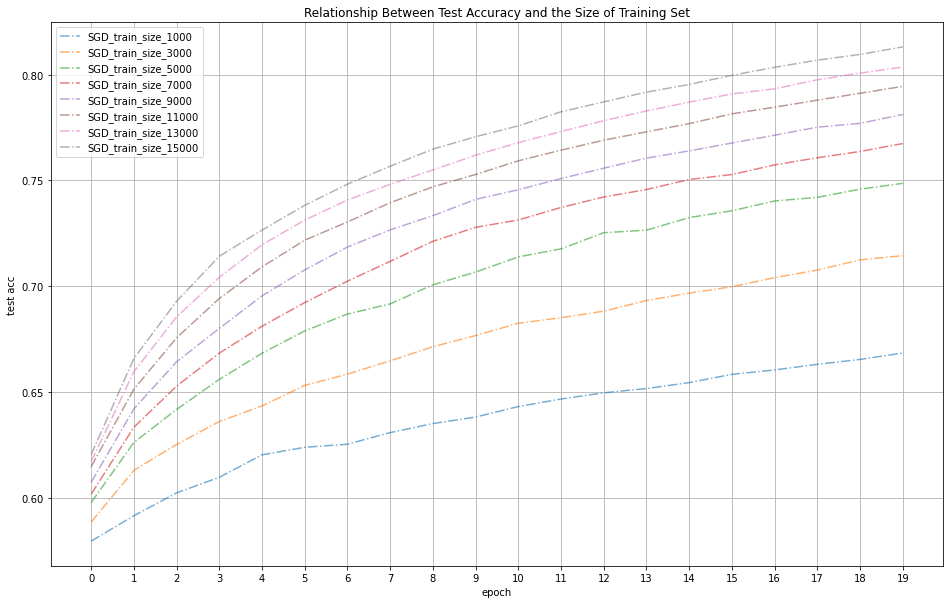

In [100]:
record_list_train_size = [beta_record[1] for beta_record in beta_records_train_size]
record_graph(record_list_train_size, 'test_acc_epoch', 'Relationship Between Test Accuracy and the Size of Training Set')

## 2. Study the relationship between test accuracy and resolution of the input image

In [26]:
import gc
## How does the accuracy depend on the resolution of the input image?

pixels = [14, 28, 56, 112]
grey = False

train_img = all_img[:15000]
train_label = attribute['Male'][:15000]
train_label = np.array(train_label).reshape(-1)

test_img = all_img[15000:]
test_label = attribute['Male'][15000:]
test_label = np.array(test_label).reshape(-1)

train_sets = []
test_sets = []
for pixel in pixels:
    res = [pixel, pixel]
    print(f"loading train set and test set with resolution {pixel} x {pixel}")
    train_sets.append((image_loader_fname(train_img, res, grey), train_label))
    test_sets.append((image_loader_fname(test_img, res, grey), test_label))

loading train set and test set with resolution 14 x 14
Number of images imported: 1000, Time elapsed: 4.15
Number of images imported: 2000, Time elapsed: 8.20
Number of images imported: 3000, Time elapsed: 12.34
Number of images imported: 4000, Time elapsed: 16.40
Number of images imported: 5000, Time elapsed: 20.54
Number of images imported: 6000, Time elapsed: 24.61
Number of images imported: 7000, Time elapsed: 28.68
Number of images imported: 8000, Time elapsed: 32.75
Number of images imported: 9000, Time elapsed: 36.83
Number of images imported: 10000, Time elapsed: 40.92
Number of images imported: 11000, Time elapsed: 45.06
Number of images imported: 12000, Time elapsed: 49.12
Number of images imported: 13000, Time elapsed: 53.19
Number of images imported: 14000, Time elapsed: 57.26
Number of images imported: 15000, Time elapsed: 61.34
Number of images imported: 1000, Time elapsed: 4.07
Number of images imported: 2000, Time elapsed: 8.15
Number of images imported: 3000, Time elap

In [27]:
beta_records_pixel = []
it = 0
for pixel in pixels:
    train_img_arr, train_label = train_sets[it]
    test_img_arr, test_label = test_sets[it]
    
    np.random.seed(42)
    beta_standard_dev = 1. / np.sqrt(3) / pixel
    beta_init = np.random.normal(0,beta_standard_dev,3*pixel*pixel)

    print(f"start model training with the train set of resolution {pixel} x {pixel}")
    beta_SGD, record_SGD = train_SGD(
    train_img_arr, train_label, test_img_arr, test_label, beta_init, 1e-7, loss_LR_values_and_grad, n_epoch = 20, mb_size = 32, verbose = 1)
    record_SGD['name'] += f"_res_{pixel}x{pixel}"
    beta_records_pixel.append((beta_SGD, record_SGD))
    
    train_sets[it], test_sets[it] = 0, 0
    del train_img_arr, train_label, test_img_arr, test_label
    it += 1

start model training with the train set of resolution 14 x 14
Epoch 0: 0.91 seconds, Loss: 18.28, Test Accuracy: 0.516
Epoch 1: 0.56 seconds, Loss: 17.19, Test Accuracy: 0.517
Epoch 2: 0.56 seconds, Loss: 16.30, Test Accuracy: 0.518
Epoch 3: 0.56 seconds, Loss: 15.53, Test Accuracy: 0.520
Epoch 4: 0.56 seconds, Loss: 14.88, Test Accuracy: 0.523
Epoch 5: 0.56 seconds, Loss: 14.30, Test Accuracy: 0.525
Epoch 6: 0.56 seconds, Loss: 13.79, Test Accuracy: 0.528
Epoch 7: 0.59 seconds, Loss: 13.35, Test Accuracy: 0.531
Epoch 8: 0.64 seconds, Loss: 12.94, Test Accuracy: 0.534
Epoch 9: 0.59 seconds, Loss: 12.56, Test Accuracy: 0.538
Epoch 10: 0.66 seconds, Loss: 12.20, Test Accuracy: 0.541
Epoch 11: 0.63 seconds, Loss: 11.87, Test Accuracy: 0.545
Epoch 12: 0.67 seconds, Loss: 11.57, Test Accuracy: 0.548
Epoch 13: 0.59 seconds, Loss: 11.28, Test Accuracy: 0.549
Epoch 14: 0.58 seconds, Loss: 11.01, Test Accuracy: 0.550
Epoch 15: 0.57 seconds, Loss: 10.76, Test Accuracy: 0.554
Epoch 16: 0.57 secon

In [106]:
#del train_sets, test_sets
def clear_image_cache(var_list):
    for var in var_list:
        if var in globals().keys():
            del globals()[var]
    gc.collect()
    time.sleep(1)

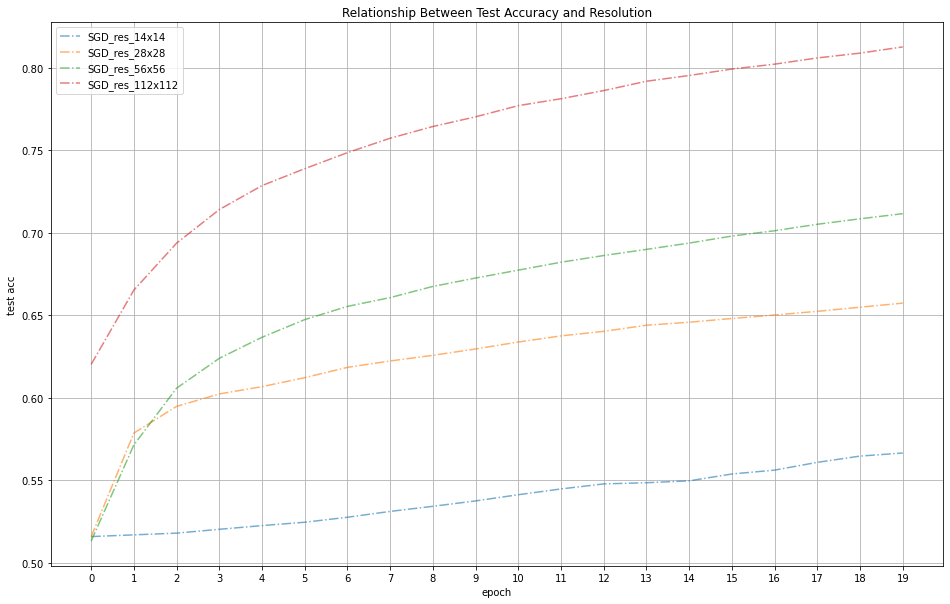

In [28]:
record_list_pixel = [beta_record[1] for beta_record in beta_records_pixel]
record_graph(record_list_pixel, 'test_acc_epoch', 'Relationship Between Test Accuracy and Resolution')

## 3. Study the relationship between test accuracy and the use of grey scale/color images

In [24]:
## Is it necessary to use colored images (or black & white images are enough)? 
# Is it helpful to increase the contrast of the images? Other preprocessing ideas?
pixel = 112
res = [pixel, pixel]

train_img = all_img[:15000]
train_label = attribute['Male'][:15000]
train_label = np.array(train_label).reshape(-1)

test_img = all_img[15000:]
test_label = attribute['Male'][15000:]
test_label = np.array(test_label).reshape(-1)

train_sets = []
test_sets = []

## original color dataset
print("loading color")
train_sets.append((image_loader_fname(train_img, res, grey=False), train_label, "Color"))
test_sets.append((image_loader_fname(test_img, res, grey=False), test_label, "Color"))

## grey scale dataset
print("loading grey scale")
train_sets.append((image_loader_fname(train_img, res, grey=True), train_label, "Grey"))
test_sets.append((image_loader_fname(test_img, res, grey=True), test_label, "Grey"))

## color adding constrast
print("loading color constrast")
train_sets.append((image_loader_fname(train_img, res, grey=False, contrast=(1.5, 0)), train_label, "Color_Contrast"))
test_sets.append((image_loader_fname(test_img, res, grey=False, contrast=(1.5, 0)), test_label, "Color_Contrast"))

## grey scale adding contrast
print("loading grey scale contrast")
train_sets.append((image_loader_fname(train_img, res, grey=True, contrast=(1.5, 0)), train_label, "Grey_Contrast"))
test_sets.append((image_loader_fname(test_img, res, grey=True, contrast=(1.5, 0)), test_label, "Grey_Contrast"))

# for pixel in pixels:
#     res = [pixel, pixel]
#     print(f"loading train set and test set with resolution {pixel} x {pixel}")
#     train_sets.append((image_loader_fname(train_img, res, grey), train_label))
#     test_sets.append((image_loader_fname(test_img, res, grey), test_label))

loading color
Number of images imported: 1000, Time elapsed: 3.55
Number of images imported: 2000, Time elapsed: 7.01
Number of images imported: 3000, Time elapsed: 10.48
Number of images imported: 4000, Time elapsed: 13.97
Number of images imported: 5000, Time elapsed: 17.46
Number of images imported: 6000, Time elapsed: 20.98
Number of images imported: 7000, Time elapsed: 24.45
Number of images imported: 8000, Time elapsed: 27.93
Number of images imported: 9000, Time elapsed: 31.42
Number of images imported: 10000, Time elapsed: 34.90
Number of images imported: 11000, Time elapsed: 38.38
Number of images imported: 12000, Time elapsed: 41.86
Number of images imported: 13000, Time elapsed: 45.33
Number of images imported: 14000, Time elapsed: 48.82
Number of images imported: 15000, Time elapsed: 52.30
Number of images imported: 1000, Time elapsed: 3.49
Number of images imported: 2000, Time elapsed: 6.97
Number of images imported: 3000, Time elapsed: 10.46
Number of images imported: 400

In [25]:
beta_records_prep = []

for it in range(4):
    train_img_arr, train_label, name = train_sets[it]
    test_img_arr, test_label, name = test_sets[it]
    if name == "Color" or name == "Color_Contrast":
        np.random.seed(42)
        beta_standard_dev = 1. / np.sqrt(3) / pixel
        beta_init = np.random.normal(0,beta_standard_dev,3*pixel*pixel)
    else:
        np.random.seed(42)
        beta_standard_dev = 1. / np.sqrt(3) / pixel
        beta_init = np.random.normal(0,beta_standard_dev,pixel*pixel)

    print(f"start model training with the {name} training set")
    beta_SGD, record_SGD = train_SGD(
    train_img_arr, train_label, test_img_arr, test_label, beta_init, 1e-7, loss_LR_values_and_grad, n_epoch = 20, mb_size = 32, verbose = 1)
    record_SGD['name'] += f"_{name}"
    beta_records_prep.append((beta_SGD, record_SGD))

start model training with the Color training set
Epoch 0: 23.72 seconds, Loss: 13.41, Test Accuracy: 0.620
Epoch 1: 16.68 seconds, Loss: 9.20, Test Accuracy: 0.665
Epoch 2: 15.63 seconds, Loss: 7.58, Test Accuracy: 0.694
Epoch 3: 16.97 seconds, Loss: 6.66, Test Accuracy: 0.714
Epoch 4: 16.22 seconds, Loss: 5.99, Test Accuracy: 0.729
Epoch 5: 17.50 seconds, Loss: 5.51, Test Accuracy: 0.739
Epoch 6: 16.78 seconds, Loss: 5.12, Test Accuracy: 0.749
Epoch 7: 16.17 seconds, Loss: 4.83, Test Accuracy: 0.757
Epoch 8: 16.16 seconds, Loss: 4.53, Test Accuracy: 0.765
Epoch 9: 16.79 seconds, Loss: 4.28, Test Accuracy: 0.770
Epoch 10: 15.28 seconds, Loss: 4.09, Test Accuracy: 0.777
Epoch 11: 15.54 seconds, Loss: 3.90, Test Accuracy: 0.781
Epoch 12: 15.53 seconds, Loss: 3.74, Test Accuracy: 0.786
Epoch 13: 15.57 seconds, Loss: 3.60, Test Accuracy: 0.792
Epoch 14: 17.30 seconds, Loss: 3.49, Test Accuracy: 0.795
Epoch 15: 16.18 seconds, Loss: 3.36, Test Accuracy: 0.799
Epoch 16: 16.88 seconds, Loss: 3

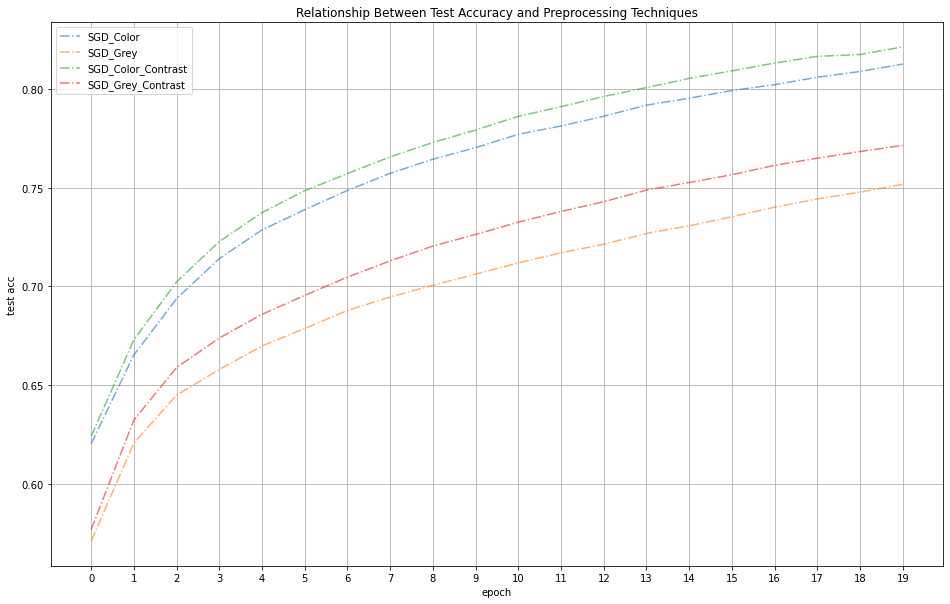

In [31]:
record_list_prep = [beta_record[1] for beta_record in beta_records_prep]
record_graph(record_list_prep, 'test_acc_epoch', 'Relationship Between Test Accuracy and Preprocessing Techniques')

## 4. Study the relationship between test accuracy and the use of only parts of face

What if one only uses the area around the eyes? Around the mouth? The hair? The ears? Etc..

### 4.1 Extract Feature

In [26]:
vertex = find_vertex(all_img)

/Users/davidlee/opt/anaconda3/envs/dsa4212/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/Users/davidlee/opt/anaconda3/envs/dsa4212/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/Users/davidlee/opt/anaconda3/envs/dsa4212/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/Users/davidlee/opt/anaconda3/envs/dsa4212/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Number of images extracted: 1000, Time elapsed: 48.94
Number of images extracted: 2000, Time elapsed: 98.16
Number of images extracted: 3000, Time elapsed: 146.88
Number of images extracted: 4000, Time elapsed: 195.68
Number of images extracted: 5000, Time elapsed: 244.45
Number of images extracted: 6000, Time elapsed: 293.42
Number of images extracted: 7000, Time elapsed: 343.18
Number of images extracted: 8000, Time elapsed: 392.40
Number of images extracted: 9000, Time elapsed: 441.72
Number of images extracted: 10000, Time elapsed: 491.52
Number of images extracted: 11000, Time elapsed: 540.99
Number of images extracted: 12000, Time elapsed: 590.21
Number of images extracted: 13000, Time elapsed: 639.31
Number of images extracted: 14000, Time elapsed: 688.84
Number of images extracted: 15000, Time elapsed: 738.28
Number of images extracted: 16000, Time elapsed: 787.63
Number of images extracted: 17000, Time elapsed: 837.14
Number of images extracted: 18000, Time elapsed: 886.11
Num

/Users/davidlee/opt/anaconda3/envs/dsa4212/lib/python3.7/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


### 4.2 Train extracted face with SGD

In [41]:
# del face_train, face_test
# gc.collect()

face_train = image_area_loader(train_img, vertex['face'], grey=False, contrast=(1.5, 0)).reshape(-1, 3 * 104 * 104)
face_test =  image_area_loader(test_img, vertex['face'], grey=False, contrast=(1.5, 0)).reshape(-1, 3 * 104 * 104)

Number of images imported: 1000, Time elapsed: 0.70
Number of images imported: 2000, Time elapsed: 1.41
Number of images imported: 3000, Time elapsed: 2.09
Number of images imported: 4000, Time elapsed: 2.77
Number of images imported: 5000, Time elapsed: 3.46
Number of images imported: 6000, Time elapsed: 4.15
Number of images imported: 7000, Time elapsed: 4.83
Number of images imported: 8000, Time elapsed: 5.52
Number of images imported: 9000, Time elapsed: 6.20
Number of images imported: 10000, Time elapsed: 6.81
Number of images imported: 11000, Time elapsed: 7.42
Number of images imported: 12000, Time elapsed: 8.04
Number of images imported: 13000, Time elapsed: 8.65
Number of images imported: 14000, Time elapsed: 9.27
Number of images imported: 15000, Time elapsed: 9.88
Number of images imported: 1000, Time elapsed: 0.62
Number of images imported: 2000, Time elapsed: 1.24
Number of images imported: 3000, Time elapsed: 1.86
Number of images imported: 4000, Time elapsed: 2.47
Number

In [42]:
# initialize beta at random
np.random.seed(42)
beta_standard_dev = 1. / np.sqrt(3) / 104
face_beta_init = np.random.normal(0,beta_standard_dev,3*104*104)

beta_face, record_face = train_SGD(
    face_train, train_label, face_test, test_label, face_beta_init, 1e-7, loss_LR_values_and_grad, n_epoch = 20, mb_size = 32, verbose = 1)

Epoch 0: 23.69 seconds, Loss: 12.38, Test Accuracy: 0.653
Epoch 1: 23.63 seconds, Loss: 8.62, Test Accuracy: 0.708
Epoch 2: 23.65 seconds, Loss: 6.90, Test Accuracy: 0.743
Epoch 3: 23.67 seconds, Loss: 6.04, Test Accuracy: 0.764
Epoch 4: 23.58 seconds, Loss: 5.37, Test Accuracy: 0.781
Epoch 5: 23.67 seconds, Loss: 4.94, Test Accuracy: 0.792
Epoch 6: 23.70 seconds, Loss: 4.64, Test Accuracy: 0.801
Epoch 7: 23.62 seconds, Loss: 4.35, Test Accuracy: 0.811
Epoch 8: 23.59 seconds, Loss: 4.12, Test Accuracy: 0.816
Epoch 9: 23.62 seconds, Loss: 3.91, Test Accuracy: 0.822
Epoch 10: 23.68 seconds, Loss: 3.72, Test Accuracy: 0.827
Epoch 11: 23.69 seconds, Loss: 3.62, Test Accuracy: 0.830
Epoch 12: 23.63 seconds, Loss: 3.49, Test Accuracy: 0.833
Epoch 13: 23.66 seconds, Loss: 3.37, Test Accuracy: 0.837
Epoch 14: 23.68 seconds, Loss: 3.31, Test Accuracy: 0.840
Epoch 15: 23.65 seconds, Loss: 3.20, Test Accuracy: 0.842
Epoch 16: 23.68 seconds, Loss: 3.14, Test Accuracy: 0.844
Epoch 17: 23.67 seconds

### 4.3 Train extracted nose with SGD

In [43]:
nose_train = image_area_loader(train_img, vertex['nose'], grey=False, contrast=(1.5, 0)).reshape(-1, 3 * 30 * 25)
nose_test =  image_area_loader(test_img, vertex['nose'], grey=False, contrast=(1.5, 0)).reshape(-1, 3 * 30 * 25)

Number of images imported: 1000, Time elapsed: 0.62
Number of images imported: 2000, Time elapsed: 1.22
Number of images imported: 3000, Time elapsed: 1.82
Number of images imported: 4000, Time elapsed: 2.44
Number of images imported: 5000, Time elapsed: 3.04
Number of images imported: 6000, Time elapsed: 3.65
Number of images imported: 7000, Time elapsed: 4.26
Number of images imported: 8000, Time elapsed: 4.89
Number of images imported: 9000, Time elapsed: 5.53
Number of images imported: 10000, Time elapsed: 6.15
Number of images imported: 11000, Time elapsed: 6.78
Number of images imported: 12000, Time elapsed: 7.38
Number of images imported: 13000, Time elapsed: 7.99
Number of images imported: 14000, Time elapsed: 8.59
Number of images imported: 15000, Time elapsed: 9.19
Number of images imported: 1000, Time elapsed: 0.61
Number of images imported: 2000, Time elapsed: 1.22
Number of images imported: 3000, Time elapsed: 1.84
Number of images imported: 4000, Time elapsed: 2.44
Number

In [45]:
# initialize beta at random
np.random.seed(42)
beta_standard_dev = 1. / np.sqrt(3) / np.sqrt(30*25)
nose_beta_init = np.random.normal(0,beta_standard_dev,3*30*25)

beta_nose, record_nose = train_SGD(
    nose_train, train_label, nose_test, test_label, nose_beta_init, 1e-7, loss_LR_values_and_grad, n_epoch = 20, mb_size = 32, verbose = 1)

Epoch 0: 1.57 seconds, Loss: 26.63, Test Accuracy: 0.571
Epoch 1: 1.48 seconds, Loss: 11.67, Test Accuracy: 0.598
Epoch 2: 1.48 seconds, Loss: 10.63, Test Accuracy: 0.600
Epoch 3: 1.47 seconds, Loss: 9.80, Test Accuracy: 0.601
Epoch 4: 1.49 seconds, Loss: 9.16, Test Accuracy: 0.603
Epoch 5: 1.49 seconds, Loss: 8.65, Test Accuracy: 0.605
Epoch 6: 1.49 seconds, Loss: 8.27, Test Accuracy: 0.607
Epoch 7: 1.49 seconds, Loss: 7.92, Test Accuracy: 0.608
Epoch 8: 1.48 seconds, Loss: 7.66, Test Accuracy: 0.609
Epoch 9: 1.50 seconds, Loss: 7.43, Test Accuracy: 0.610
Epoch 10: 1.48 seconds, Loss: 7.23, Test Accuracy: 0.611
Epoch 11: 1.48 seconds, Loss: 7.06, Test Accuracy: 0.612
Epoch 12: 1.49 seconds, Loss: 6.91, Test Accuracy: 0.614
Epoch 13: 1.48 seconds, Loss: 6.78, Test Accuracy: 0.614
Epoch 14: 1.53 seconds, Loss: 6.66, Test Accuracy: 0.615
Epoch 15: 1.50 seconds, Loss: 6.55, Test Accuracy: 0.616
Epoch 16: 1.49 seconds, Loss: 6.44, Test Accuracy: 0.616
Epoch 17: 1.50 seconds, Loss: 6.36, Te

### 4.4 Train extracted eyes with SGD

In [46]:
eyes_train = image_area_loader(train_img, vertex['eyes'], grey=False, contrast=(1.5, 0)).reshape(-1, 3 * 27 * 27)
eyes_test =  image_area_loader(test_img, vertex['eyes'], grey=False, contrast=(1.5, 0)).reshape(-1, 3 * 27 * 27)

Number of images imported: 1000, Time elapsed: 0.63
Number of images imported: 2000, Time elapsed: 1.23
Number of images imported: 3000, Time elapsed: 1.83
Number of images imported: 4000, Time elapsed: 2.44
Number of images imported: 5000, Time elapsed: 3.06
Number of images imported: 6000, Time elapsed: 3.66
Number of images imported: 7000, Time elapsed: 4.26
Number of images imported: 8000, Time elapsed: 4.89
Number of images imported: 9000, Time elapsed: 5.50
Number of images imported: 10000, Time elapsed: 6.11
Number of images imported: 11000, Time elapsed: 6.72
Number of images imported: 12000, Time elapsed: 7.34
Number of images imported: 13000, Time elapsed: 7.96
Number of images imported: 14000, Time elapsed: 8.55
Number of images imported: 15000, Time elapsed: 9.16
Number of images imported: 1000, Time elapsed: 0.63
Number of images imported: 2000, Time elapsed: 1.24
Number of images imported: 3000, Time elapsed: 1.86
Number of images imported: 4000, Time elapsed: 2.47
Number

In [49]:
# initialize beta at random
np.random.seed(42)
beta_standard_dev = 1. / np.sqrt(3) / np.sqrt(27*27)
eyes_beta_init = np.random.normal(0,beta_standard_dev,3*27*27)

beta_eyes, record_eyes = train_SGD(
    eyes_train, train_label, eyes_test, test_label, eyes_beta_init, 1e-6, loss_LR_values_and_grad, n_epoch = 20, mb_size = 32, verbose = 1)

Epoch 0: 1.49 seconds, Loss: 10.48, Test Accuracy: 0.630
Epoch 1: 1.47 seconds, Loss: 6.03, Test Accuracy: 0.684
Epoch 2: 1.47 seconds, Loss: 5.26, Test Accuracy: 0.708
Epoch 3: 1.47 seconds, Loss: 4.78, Test Accuracy: 0.724
Epoch 4: 1.46 seconds, Loss: 4.51, Test Accuracy: 0.733
Epoch 5: 1.47 seconds, Loss: 4.31, Test Accuracy: 0.738
Epoch 6: 1.47 seconds, Loss: 4.11, Test Accuracy: 0.741
Epoch 7: 1.47 seconds, Loss: 3.97, Test Accuracy: 0.744
Epoch 8: 1.47 seconds, Loss: 3.85, Test Accuracy: 0.747
Epoch 9: 1.46 seconds, Loss: 3.68, Test Accuracy: 0.749
Epoch 10: 1.47 seconds, Loss: 3.53, Test Accuracy: 0.752
Epoch 11: 1.47 seconds, Loss: 3.48, Test Accuracy: 0.752
Epoch 12: 1.47 seconds, Loss: 3.34, Test Accuracy: 0.754
Epoch 13: 1.47 seconds, Loss: 3.29, Test Accuracy: 0.755
Epoch 14: 1.47 seconds, Loss: 3.18, Test Accuracy: 0.758
Epoch 15: 1.47 seconds, Loss: 3.15, Test Accuracy: 0.756
Epoch 16: 1.47 seconds, Loss: 3.07, Test Accuracy: 0.758
Epoch 17: 1.48 seconds, Loss: 3.13, Test

### 4.5 Train extracted mouth with SGD

In [50]:
mouth_train = image_area_loader(train_img, vertex['mouth'], grey=False, contrast=(1.5, 0)).reshape(-1, 3 * 40 * 24)
mouth_test =  image_area_loader(test_img, vertex['mouth'], grey=False, contrast=(1.5, 0)).reshape(-1, 3 * 40 * 24)

Number of images imported: 1000, Time elapsed: 0.63
Number of images imported: 2000, Time elapsed: 1.25
Number of images imported: 3000, Time elapsed: 1.84
Number of images imported: 4000, Time elapsed: 2.44
Number of images imported: 5000, Time elapsed: 3.03
Number of images imported: 6000, Time elapsed: 3.64
Number of images imported: 7000, Time elapsed: 4.25
Number of images imported: 8000, Time elapsed: 4.85
Number of images imported: 9000, Time elapsed: 5.48
Number of images imported: 10000, Time elapsed: 6.12
Number of images imported: 11000, Time elapsed: 6.75
Number of images imported: 12000, Time elapsed: 7.42
Number of images imported: 13000, Time elapsed: 8.07
Number of images imported: 14000, Time elapsed: 8.74
Number of images imported: 15000, Time elapsed: 9.38
Number of images imported: 1000, Time elapsed: 0.66
Number of images imported: 2000, Time elapsed: 1.29
Number of images imported: 3000, Time elapsed: 1.92
Number of images imported: 4000, Time elapsed: 2.57
Number

In [51]:
# initialize beta at random
np.random.seed(42)
beta_standard_dev = 1. / np.sqrt(3) / np.sqrt(40*24)
mouth_beta_init = np.random.normal(0,beta_standard_dev,3*40*24)

beta_mouth, record_mouth = train_SGD(
    mouth_train, train_label, mouth_test, test_label, mouth_beta_init, 1e-6, loss_LR_values_and_grad, n_epoch = 20, mb_size = 32, verbose = 1)

Epoch 0: 1.97 seconds, Loss: 13.82, Test Accuracy: 0.553
Epoch 1: 1.80 seconds, Loss: 8.43, Test Accuracy: 0.593
Epoch 2: 1.80 seconds, Loss: 7.36, Test Accuracy: 0.615
Epoch 3: 1.79 seconds, Loss: 7.06, Test Accuracy: 0.624
Epoch 4: 1.80 seconds, Loss: 6.54, Test Accuracy: 0.632
Epoch 5: 1.80 seconds, Loss: 5.95, Test Accuracy: 0.640
Epoch 6: 1.80 seconds, Loss: 6.21, Test Accuracy: 0.640
Epoch 7: 1.80 seconds, Loss: 5.82, Test Accuracy: 0.646
Epoch 8: 1.80 seconds, Loss: 5.61, Test Accuracy: 0.652
Epoch 9: 1.80 seconds, Loss: 5.56, Test Accuracy: 0.653
Epoch 10: 1.80 seconds, Loss: 5.36, Test Accuracy: 0.659
Epoch 11: 1.80 seconds, Loss: 5.40, Test Accuracy: 0.660
Epoch 12: 1.80 seconds, Loss: 5.26, Test Accuracy: 0.664
Epoch 13: 1.80 seconds, Loss: 5.06, Test Accuracy: 0.666
Epoch 14: 1.80 seconds, Loss: 5.29, Test Accuracy: 0.665
Epoch 15: 1.81 seconds, Loss: 4.98, Test Accuracy: 0.669
Epoch 16: 1.81 seconds, Loss: 4.86, Test Accuracy: 0.672
Epoch 17: 1.80 seconds, Loss: 5.01, Test

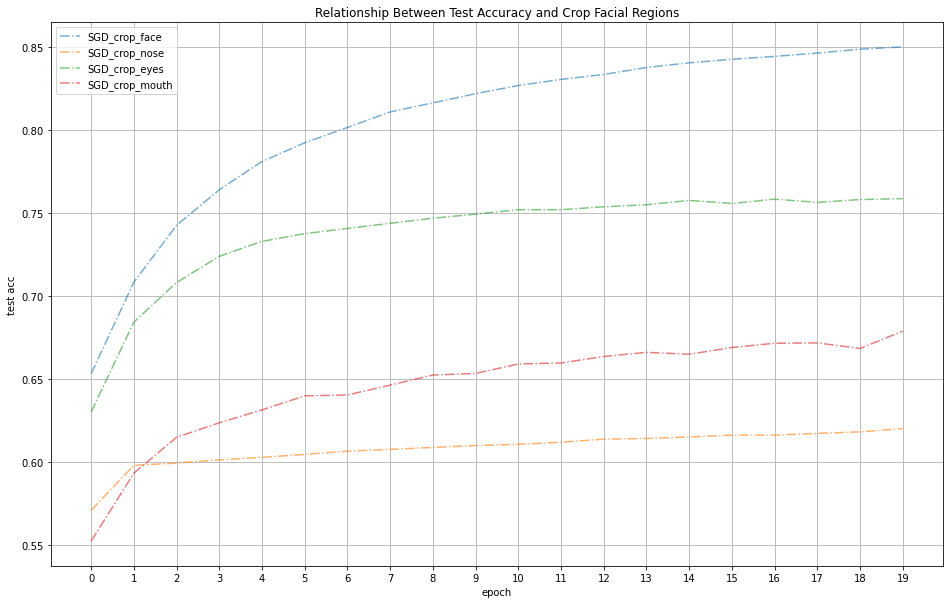

In [77]:
record_face['name'] ="SGD_crop_face"
record_nose['name'] ="SGD_crop_nose"
record_eyes['name'] ="SGD_crop_eyes"
record_mouth['name'] ="SGD_crop_mouth"

record_list_parts = [record_face, record_nose, record_eyes, record_mouth]
record_graph(record_list_parts, 'test_acc_epoch', "Relationship Between Test Accuracy and Crop Facial Regions")

## 5. Ensemble model of facial regions

In [60]:
nose_prob_train = pred_proba_batch(beta_nose, nose_train)
eyes_prob_train = pred_proba_batch(beta_eyes, eyes_train)
mouth_prob_train = pred_proba_batch(beta_mouth, mouth_train)

nose_prob_test = pred_proba_batch(beta_nose, nose_test)
eyes_prob_test = pred_proba_batch(beta_eyes, eyes_test)
mouth_prob_test = pred_proba_batch(beta_mouth, mouth_test)

In [61]:
ensemble_train = np.column_stack((nose_prob_train,  eyes_prob_train, mouth_prob_train))
ensemble_test = np.column_stack((nose_prob_test,  eyes_prob_test, mouth_prob_test))
print(ensemble_train.shape)
print(ensemble_test.shape)

(15000, 3)
(5000, 3)


In [72]:
# initialize beta at random
np.random.seed(42)
beta_standard_dev = 1. / np.sqrt(3) 
ensemble_beta_init = np.random.normal(0,beta_standard_dev,3)

beta_ensemble, record_ensemble = train_SGD(
    ensemble_train, train_label, ensemble_test, test_label, ensemble_beta_init, 1, loss_LR_values_and_grad, n_epoch = 20, mb_size = 15000, verbose = 1)

Epoch 0: 0.01 seconds, Loss: 0.69, Test Accuracy: 0.454
Epoch 1: 0.00 seconds, Loss: 0.68, Test Accuracy: 0.421
Epoch 2: 0.00 seconds, Loss: 0.67, Test Accuracy: 0.421
Epoch 3: 0.00 seconds, Loss: 0.67, Test Accuracy: 0.421
Epoch 4: 0.00 seconds, Loss: 0.66, Test Accuracy: 0.523
Epoch 5: 0.00 seconds, Loss: 0.66, Test Accuracy: 0.638
Epoch 6: 0.00 seconds, Loss: 0.66, Test Accuracy: 0.643
Epoch 7: 0.00 seconds, Loss: 0.65, Test Accuracy: 0.646
Epoch 8: 0.00 seconds, Loss: 0.65, Test Accuracy: 0.647
Epoch 9: 0.00 seconds, Loss: 0.65, Test Accuracy: 0.649
Epoch 10: 0.00 seconds, Loss: 0.65, Test Accuracy: 0.650
Epoch 11: 0.00 seconds, Loss: 0.65, Test Accuracy: 0.651
Epoch 12: 0.00 seconds, Loss: 0.65, Test Accuracy: 0.652
Epoch 13: 0.00 seconds, Loss: 0.65, Test Accuracy: 0.652
Epoch 14: 0.00 seconds, Loss: 0.64, Test Accuracy: 0.653
Epoch 15: 0.00 seconds, Loss: 0.64, Test Accuracy: 0.654
Epoch 16: 0.00 seconds, Loss: 0.64, Test Accuracy: 0.655
Epoch 17: 0.00 seconds, Loss: 0.64, Test 

In [73]:
# Give the prediction by majority voting
def ensemble_voting(ensemble):
    voting = np.mean(ensemble_test > 0.5 , axis = 1)
    pred = np.array([1 if v > 0.5 else 0 for v in voting])
    return pred

In [70]:
get_accuracy(ensemble_voting(ensemble_test), test_label)

DeviceArray(0.7256, dtype=float64)

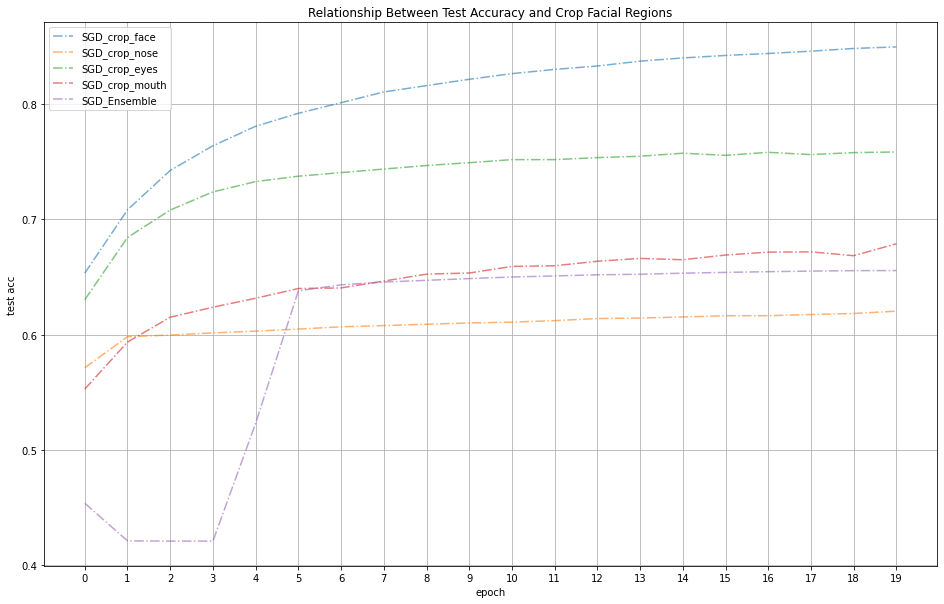

In [76]:
record_ensemble['name'] = "SGD_Ensemble"
record_face['name'] ="SGD_crop_face"
record_nose['name'] ="SGD_crop_nose"
record_eyes['name'] ="SGD_crop_eyes"
record_mouth['name'] ="SGD_crop_mouth"

record_list_parts = [record_face, record_nose, record_eyes, record_mouth, record_ensemble]
record_graph(record_list_parts, 'test_acc_epoch', "Relationship Between Test Accuracy and Crop Facial Regions")

## 6. Optimization Algorithm Selection

In [26]:
## Based on previous preprocessing and training setup
# we will only use face crop of the image
vertex = find_vertex(all_img)

/Users/davidlee/opt/anaconda3/envs/dsa4212/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/Users/davidlee/opt/anaconda3/envs/dsa4212/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/Users/davidlee/opt/anaconda3/envs/dsa4212/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/Users/davidlee/opt/anaconda3/envs/dsa4212/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Number of images extracted: 1000, Time elapsed: 49.70
Number of images extracted: 2000, Time elapsed: 99.35
Number of images extracted: 3000, Time elapsed: 148.44
Number of images extracted: 4000, Time elapsed: 197.63
Number of images extracted: 5000, Time elapsed: 246.83
Number of images extracted: 6000, Time elapsed: 295.99
Number of images extracted: 7000, Time elapsed: 345.74
Number of images extracted: 8000, Time elapsed: 395.00
Number of images extracted: 9000, Time elapsed: 444.38
Number of images extracted: 10000, Time elapsed: 494.12
Number of images extracted: 11000, Time elapsed: 543.60
Number of images extracted: 12000, Time elapsed: 592.77
Number of images extracted: 13000, Time elapsed: 641.70
Number of images extracted: 14000, Time elapsed: 691.23
Number of images extracted: 15000, Time elapsed: 740.88
Number of images extracted: 16000, Time elapsed: 790.48
Number of images extracted: 17000, Time elapsed: 840.17
Number of images extracted: 18000, Time elapsed: 889.67
Num

/Users/davidlee/opt/anaconda3/envs/dsa4212/lib/python3.7/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


In [28]:
# del face_train, face_test
# gc.collect()

face_train = image_area_loader(train_img, vertex['face'], grey=False).reshape(-1, 3 * 104 * 104)
face_test =  image_area_loader(test_img, vertex['face'], grey=False).reshape(-1, 3 * 104 * 104)

Number of images imported: 1000, Time elapsed: 0.64
Number of images imported: 2000, Time elapsed: 1.24
Number of images imported: 3000, Time elapsed: 1.84
Number of images imported: 4000, Time elapsed: 2.44
Number of images imported: 5000, Time elapsed: 3.04
Number of images imported: 6000, Time elapsed: 3.65
Number of images imported: 7000, Time elapsed: 4.25
Number of images imported: 8000, Time elapsed: 4.85
Number of images imported: 9000, Time elapsed: 5.45
Number of images imported: 10000, Time elapsed: 6.06
Number of images imported: 11000, Time elapsed: 6.66
Number of images imported: 12000, Time elapsed: 7.27
Number of images imported: 13000, Time elapsed: 7.87
Number of images imported: 14000, Time elapsed: 8.49
Number of images imported: 15000, Time elapsed: 9.16
Number of images imported: 1000, Time elapsed: 0.64
Number of images imported: 2000, Time elapsed: 1.26
Number of images imported: 3000, Time elapsed: 1.89
Number of images imported: 4000, Time elapsed: 2.51
Number

In [63]:
# initialize beta at random
np.random.seed(42)
beta_standard_dev = 1. / np.sqrt(3) / 104
face_beta_init = np.random.normal(0,beta_standard_dev,3*104*104)

### 6.1 Standard SGD

In [31]:
beta_SGD, record_SGD = train_SGD(
    face_train, train_label, face_test, test_label, face_beta_init, 1e-7, loss_LR_values_and_grad, n_epoch = 20, mb_size = 32, verbose = 1)

Epoch 0: 16.19 seconds, Loss: 9.26, Test Accuracy: 0.668
Epoch 1: 12.27 seconds, Loss: 6.59, Test Accuracy: 0.717
Epoch 2: 12.29 seconds, Loss: 5.39, Test Accuracy: 0.748
Epoch 3: 12.26 seconds, Loss: 4.69, Test Accuracy: 0.770
Epoch 4: 12.26 seconds, Loss: 4.17, Test Accuracy: 0.787
Epoch 5: 12.23 seconds, Loss: 3.81, Test Accuracy: 0.797
Epoch 6: 12.27 seconds, Loss: 3.56, Test Accuracy: 0.805
Epoch 7: 12.26 seconds, Loss: 3.34, Test Accuracy: 0.813
Epoch 8: 12.24 seconds, Loss: 3.16, Test Accuracy: 0.819
Epoch 9: 12.22 seconds, Loss: 2.99, Test Accuracy: 0.823
Epoch 10: 12.22 seconds, Loss: 2.86, Test Accuracy: 0.828
Epoch 11: 12.25 seconds, Loss: 2.74, Test Accuracy: 0.832
Epoch 12: 12.22 seconds, Loss: 2.66, Test Accuracy: 0.836
Epoch 13: 12.23 seconds, Loss: 2.57, Test Accuracy: 0.839
Epoch 14: 12.22 seconds, Loss: 2.51, Test Accuracy: 0.843
Epoch 15: 12.25 seconds, Loss: 2.44, Test Accuracy: 0.845
Epoch 16: 12.25 seconds, Loss: 2.36, Test Accuracy: 0.847
Epoch 17: 12.26 seconds,

### 6.2 SGD Annealing with Learning Rate Step Decay

In [32]:
beta_step, record_step = train_SGD_step_decay(
    face_train, train_label, face_test, test_label, face_beta_init, 1e-7, loss_LR_values_and_grad, n_epoch = 20, mb_size=32, verbose = 1)

Epoch 0: 12.52 seconds, Loss: 9.26, Test Accuracy: 0.666
Epoch 1: 12.24 seconds, Loss: 6.60, Test Accuracy: 0.717
Epoch 2: 12.25 seconds, Loss: 5.40, Test Accuracy: 0.748
Epoch 3: 12.33 seconds, Loss: 4.71, Test Accuracy: 0.771
Epoch 4: 12.23 seconds, Loss: 4.20, Test Accuracy: 0.785
Epoch 5: 12.22 seconds, Loss: 3.83, Test Accuracy: 0.798
Epoch 6: 12.24 seconds, Loss: 3.67, Test Accuracy: 0.802
Epoch 7: 12.25 seconds, Loss: 3.53, Test Accuracy: 0.806
Epoch 8: 12.23 seconds, Loss: 3.41, Test Accuracy: 0.810
Epoch 9: 12.23 seconds, Loss: 3.30, Test Accuracy: 0.813
Epoch 10: 12.23 seconds, Loss: 3.20, Test Accuracy: 0.816
Epoch 11: 12.28 seconds, Loss: 3.15, Test Accuracy: 0.818
Epoch 12: 12.29 seconds, Loss: 3.11, Test Accuracy: 0.819
Epoch 13: 12.25 seconds, Loss: 3.07, Test Accuracy: 0.820
Epoch 14: 12.23 seconds, Loss: 3.03, Test Accuracy: 0.821
Epoch 15: 12.23 seconds, Loss: 2.99, Test Accuracy: 0.822
Epoch 16: 12.26 seconds, Loss: 2.97, Test Accuracy: 0.823
Epoch 17: 12.27 seconds,

### 6.3 SGD Annealing with Heuristic

In [33]:
beta_heuristic, record_heuristic = train_SGD_heuristic(
    face_train, train_label, face_test, test_label, face_beta_init, 1e-7, loss_LR_values_and_grad, n_epoch = 20,  mb_size=32, verbose = 1)

Epoch 0: 12.78 seconds, Loss: 9.22, Test Accuracy: 0.667
Epoch 1: 12.32 seconds, Loss: 6.60, Test Accuracy: 0.717
Epoch 2: 12.28 seconds, Loss: 5.42, Test Accuracy: 0.748
Epoch 3: 12.28 seconds, Loss: 4.69, Test Accuracy: 0.772
Epoch 4: 12.28 seconds, Loss: 4.18, Test Accuracy: 0.786
Epoch 5: 12.29 seconds, Loss: 3.81, Test Accuracy: 0.798
Epoch 6: 12.26 seconds, Loss: 3.53, Test Accuracy: 0.806
Epoch 7: 12.32 seconds, Loss: 3.34, Test Accuracy: 0.813
Epoch 8: 12.30 seconds, Loss: 3.14, Test Accuracy: 0.819
Epoch 9: 12.30 seconds, Loss: 2.98, Test Accuracy: 0.824
Epoch 10: 12.25 seconds, Loss: 2.86, Test Accuracy: 0.828
Epoch 11: 12.26 seconds, Loss: 2.72, Test Accuracy: 0.833
Epoch 12: 12.27 seconds, Loss: 2.68, Test Accuracy: 0.834
Epoch 13: 12.27 seconds, Loss: 2.62, Test Accuracy: 0.836
Epoch 14: 12.29 seconds, Loss: 2.58, Test Accuracy: 0.837
Epoch 15: 12.27 seconds, Loss: 2.56, Test Accuracy: 0.838
Epoch 16: 12.27 seconds, Loss: 2.54, Test Accuracy: 0.838
Epoch 17: 12.30 seconds,

### 6.4 SGD Annealing with 1/t Scheduled Decay

In [67]:
beta_schedule, record_schedule = train_SGD_scheduled_decay(
    face_train, train_label, face_test, test_label, face_beta_init, 1e-6, loss_LR_values_and_grad, n_epoch = 20, mb_size = 32, verbose = 1, decay_constant=0.02)

Epoch 0: 12.30 seconds, Loss: 28.91, Test Accuracy: 0.654
Epoch 1: 12.28 seconds, Loss: 12.77, Test Accuracy: 0.776
Epoch 2: 12.27 seconds, Loss: 8.21, Test Accuracy: 0.822
Epoch 3: 12.27 seconds, Loss: 6.25, Test Accuracy: 0.843
Epoch 4: 12.28 seconds, Loss: 4.83, Test Accuracy: 0.863
Epoch 5: 12.27 seconds, Loss: 3.90, Test Accuracy: 0.877
Epoch 6: 12.27 seconds, Loss: 3.22, Test Accuracy: 0.885
Epoch 7: 12.31 seconds, Loss: 2.75, Test Accuracy: 0.893
Epoch 8: 12.29 seconds, Loss: 2.52, Test Accuracy: 0.896
Epoch 9: 12.28 seconds, Loss: 2.30, Test Accuracy: 0.900
Epoch 10: 12.31 seconds, Loss: 2.12, Test Accuracy: 0.903
Epoch 11: 12.27 seconds, Loss: 1.96, Test Accuracy: 0.905
Epoch 12: 12.32 seconds, Loss: 1.90, Test Accuracy: 0.907
Epoch 13: 12.33 seconds, Loss: 1.81, Test Accuracy: 0.908
Epoch 14: 12.29 seconds, Loss: 1.75, Test Accuracy: 0.909
Epoch 15: 12.27 seconds, Loss: 1.71, Test Accuracy: 0.909
Epoch 16: 12.30 seconds, Loss: 1.67, Test Accuracy: 0.910
Epoch 17: 12.55 second

### 6.5 SGD with Momentum

In [66]:
beta_mom, record_mom = train_SGD_mom(
    face_train, train_label, face_test, test_label, face_beta_init, 1e-7, loss_LR_values_and_grad, n_epoch = 20, mb_size = 32, verbose = 1, mom_constant=0.9)

Epoch 0: 12.38 seconds, Loss: 6.73, Test Accuracy: 0.748
Epoch 1: 12.35 seconds, Loss: 3.35, Test Accuracy: 0.837
Epoch 2: 12.30 seconds, Loss: 2.66, Test Accuracy: 0.855
Epoch 3: 12.29 seconds, Loss: 2.56, Test Accuracy: 0.859
Epoch 4: 12.32 seconds, Loss: 2.37, Test Accuracy: 0.868
Epoch 5: 12.33 seconds, Loss: 2.24, Test Accuracy: 0.870
Epoch 6: 12.30 seconds, Loss: 2.02, Test Accuracy: 0.877
Epoch 7: 12.32 seconds, Loss: 1.97, Test Accuracy: 0.879
Epoch 8: 12.43 seconds, Loss: 1.88, Test Accuracy: 0.885
Epoch 9: 12.54 seconds, Loss: 1.70, Test Accuracy: 0.888
Epoch 10: 12.43 seconds, Loss: 1.80, Test Accuracy: 0.883
Epoch 11: 12.39 seconds, Loss: 1.51, Test Accuracy: 0.892
Epoch 12: 12.30 seconds, Loss: 1.73, Test Accuracy: 0.886
Epoch 13: 12.47 seconds, Loss: 1.51, Test Accuracy: 0.895
Epoch 14: 12.43 seconds, Loss: 1.53, Test Accuracy: 0.890
Epoch 15: 12.37 seconds, Loss: 1.32, Test Accuracy: 0.900
Epoch 16: 12.41 seconds, Loss: 1.53, Test Accuracy: 0.891
Epoch 17: 12.39 seconds,

### 6.5.1 SGD with Momentum and Scheduled Decay

In [70]:
beta_mom_schedule, record_mom_schedule = train_SGD_mom_scheduled_decay(
    face_train, train_label, face_test, test_label, face_beta_init, 1e-6, loss_LR_values_and_grad, n_epoch = 20, mb_size = 32, verbose = 1, decay_constant=0.02, mom_constant=0.9)

Epoch 0: 12.43 seconds, Loss: 14.85, Test Accuracy: 0.797
Epoch 1: 12.31 seconds, Loss: 10.29, Test Accuracy: 0.852
Epoch 2: 12.30 seconds, Loss: 12.22, Test Accuracy: 0.853
Epoch 3: 12.30 seconds, Loss: 10.45, Test Accuracy: 0.874
Epoch 4: 12.33 seconds, Loss: 9.55, Test Accuracy: 0.878
Epoch 5: 12.36 seconds, Loss: 8.49, Test Accuracy: 0.882
Epoch 6: 12.35 seconds, Loss: 7.18, Test Accuracy: 0.894
Epoch 7: 12.32 seconds, Loss: 9.02, Test Accuracy: 0.879
Epoch 8: 12.32 seconds, Loss: 5.37, Test Accuracy: 0.907
Epoch 9: 12.31 seconds, Loss: 4.40, Test Accuracy: 0.915
Epoch 10: 12.32 seconds, Loss: 4.14, Test Accuracy: 0.915
Epoch 11: 12.33 seconds, Loss: 3.46, Test Accuracy: 0.919
Epoch 12: 12.32 seconds, Loss: 3.21, Test Accuracy: 0.920
Epoch 13: 12.31 seconds, Loss: 3.03, Test Accuracy: 0.920
Epoch 14: 12.36 seconds, Loss: 2.68, Test Accuracy: 0.925
Epoch 15: 12.33 seconds, Loss: 2.32, Test Accuracy: 0.926
Epoch 16: 12.31 seconds, Loss: 2.20, Test Accuracy: 0.928
Epoch 17: 12.33 seco

### 6.6 Quasi-Newton: BFGS

In [30]:
beta_BFGS, record_BFGS = train_BFGS(
    face_train, train_label, face_test, test_label, face_beta_init, 1e-7, loss_LR_values_and_grad, n_epoch = 20, verbose = 1)

0.5
0.25
0.125
0.0625
0.03125
0.015625
0.0078125
0.00390625
0.001953125
0.0009765625
0.00048828125
0.000244140625
0.0001220703125
6.103515625e-05
3.0517578125e-05
1.52587890625e-05
7.62939453125e-06
3.814697265625e-06
1.9073486328125e-06
9.5367431640625e-07
4.76837158203125e-07
before update B_inv
(32448, 32448)
(32448, 32448)
after update B_inv
Epoch 0: 135.01 seconds, Loss: 17.30, Test Accuracy: 0.541
0.5
0.25
0.125
0.0625
0.03125
0.015625
0.0078125
0.00390625
0.001953125
0.0009765625
0.00048828125
0.000244140625
0.0001220703125
6.103515625e-05
3.0517578125e-05
1.52587890625e-05
before update B_inv
(32448, 32448)
(32448, 32448)
after update B_inv
Epoch 1: 203.66 seconds, Loss: 17.02, Test Accuracy: 0.605
0.5
0.25
0.125
0.0625
0.03125
0.015625
0.0078125
0.00390625
0.001953125
0.0009765625
0.00048828125
0.000244140625
0.0001220703125
before update B_inv
(32448, 32448)
(32448, 32448)
after update B_inv
Epoch 2: 202.22 seconds, Loss: 14.69, Test Accuracy: 0.645
0.5
0.25
0.125
0.0625
0.03

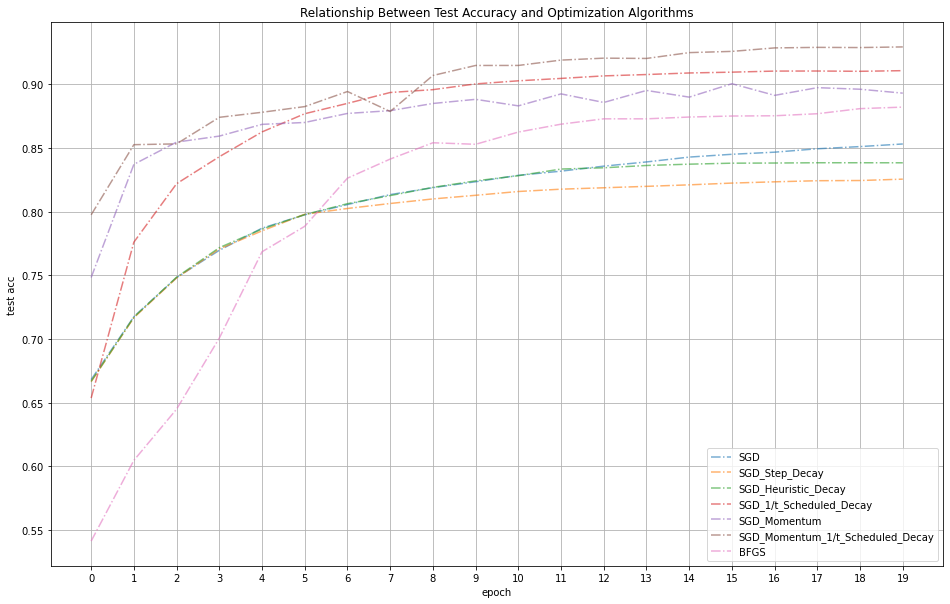

In [76]:
record_step['name'] = "SGD_Step_Decay"
record_heuristic['name'] = "SGD_Heuristic_Decay"
record_schedule['name'] = "SGD_1/t_Scheduled_Decay"
record_mom['name'] = 'SGD_Momentum'
record_mom_schedule['name'] = "SGD_Momentum_1/t_Scheduled_Decay"

record_list_optim = [record_SGD, record_step, record_heuristic, record_schedule, record_mom, record_mom_schedule, record_BFGS]
record_graph(record_list_optim, 'test_acc_epoch', "Relationship Between Test Accuracy and Optimization Algorithms")

## 7. Final Model: SGD with Momentum and 1/t Scheduled Decay

In [93]:
beta_final, record_final = train_SGD_mom_scheduled_decay(
    face_train, train_label, face_test, test_label, face_beta_init, 1e-6, loss_LR_values_and_grad, n_epoch = 30, mb_size = 32, verbose = 1, decay_constant=0.015, mom_constant=0.9)

Epoch 0: 12.39 seconds, Loss: 19.13, Test Accuracy: 0.782
Epoch 1: 12.31 seconds, Loss: 11.32, Test Accuracy: 0.855
Epoch 2: 12.29 seconds, Loss: 10.48, Test Accuracy: 0.865
Epoch 3: 12.30 seconds, Loss: 8.78, Test Accuracy: 0.879
Epoch 4: 12.30 seconds, Loss: 11.28, Test Accuracy: 0.871
Epoch 5: 12.32 seconds, Loss: 9.04, Test Accuracy: 0.881
Epoch 6: 12.30 seconds, Loss: 6.76, Test Accuracy: 0.898
Epoch 7: 12.29 seconds, Loss: 7.04, Test Accuracy: 0.892
Epoch 8: 12.30 seconds, Loss: 6.93, Test Accuracy: 0.893
Epoch 9: 12.30 seconds, Loss: 4.74, Test Accuracy: 0.913
Epoch 10: 12.34 seconds, Loss: 4.59, Test Accuracy: 0.908
Epoch 11: 12.31 seconds, Loss: 4.08, Test Accuracy: 0.913
Epoch 12: 12.31 seconds, Loss: 3.91, Test Accuracy: 0.913
Epoch 13: 12.34 seconds, Loss: 3.66, Test Accuracy: 0.915
Epoch 14: 12.30 seconds, Loss: 3.01, Test Accuracy: 0.923
Epoch 15: 12.31 seconds, Loss: 2.57, Test Accuracy: 0.924
Epoch 16: 12.31 seconds, Loss: 2.32, Test Accuracy: 0.927
Epoch 17: 12.30 seco

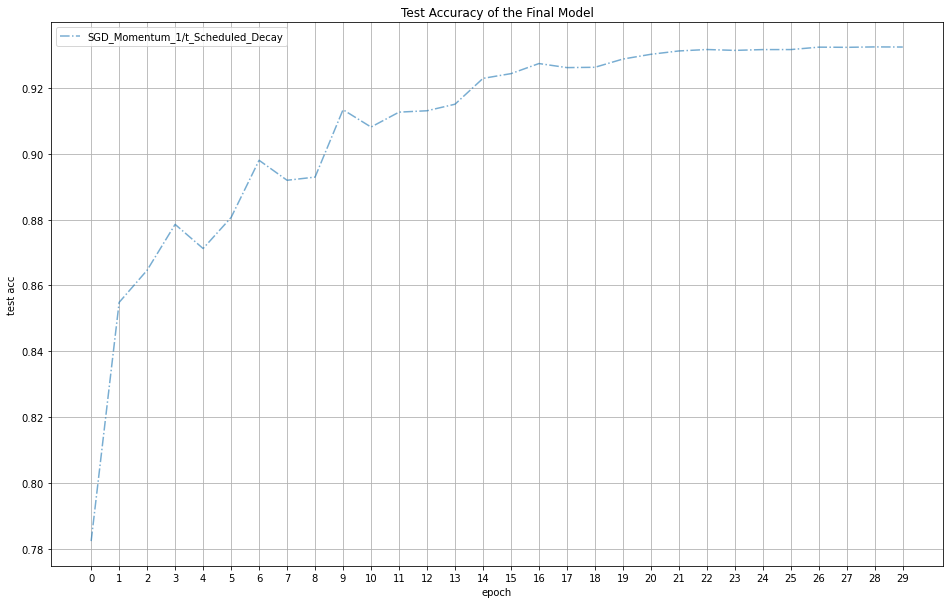

In [95]:
record_final['name'] = "SGD_Momentum_1/t_Scheduled_Decay"
record_graph([record_final], 'test_acc_epoch', "Test Accuracy of the Final Model")
plt.legend(loc='upper left')

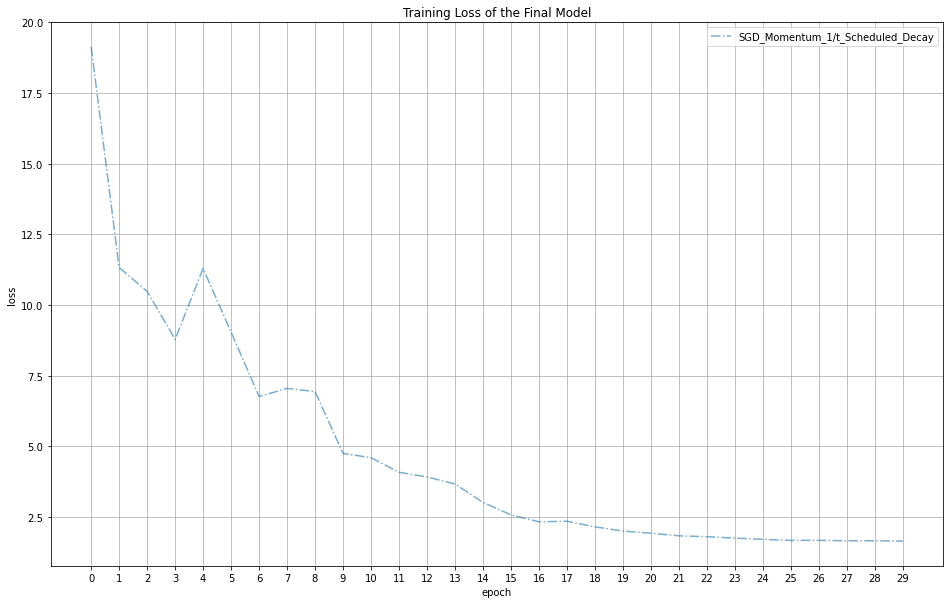

In [96]:
record_graph([record_final], 'loss_epoch', "Training Loss of the Final Model")

### 7.1 Report Final Model Accuracy and AUC on Test Set

In [103]:
acc_test_final, auc_test_final = test_acc_auc(beta_final, test_label, face_test)

Test Accuracy is 0.93
Test AUC is 0.97


## 8. Training with only 200 images?

In [51]:
## with fixed mom_constant
def train_SGD_mom(train_img, train_label, beta_init, lr, val_grad_fn, lr_decay=0.5, n_steps=5, verbose = 0, n_epoch=10, mb_size=100, mom_constant=0.5):
    """
     Find optimized beta given train images and train labels with fix epoch learning rate decay using SGD plus momentum
     
    Inputs:
     train_img: Training images (in the format of [n,:] array, where n is the number of images)
     train_label: Training labels (in the format of [n, 1] array, where n is the number of labels)
     beta: Starting point of beta (weights)
     lr: Learning rate
     val_grad_fn: Function to return the loss value and gradient given X and Y
     lr_decay: Learning rate decay rate, default 0.5
     n_steps: Number of epochs to decay the learning rate
     verbose: Print time elapsed, training loss and test accuracy for each epoch if verbose = 1, default 0
     n_epoch: Number of epoch to run the algo, default 10
     mb_size: Minibatch size, default 100
     mom_constant: choise of momentum constant, default 0.5

    Outputs:
     beta: The final updated values of beta
     record: A dictionary of performance during training, including 'loss_epoch', 'loss_mb', 'test_acc_epoch', 'test_acc_mb' 
    """
    minibatch_size = mb_size #size of the minibatchs
    N = len(train_img)  #15000, total number of images
    img_indices = np.arange(N)

    loss_history_epoch = []
    loss_history_mb = []
    test_acc_history_epoch = []
    test_acc_history_mb = []
    
    beta = np.copy(beta_init)
    beta_old = np.copy(beta_init)
    learning_rate = lr
    
    np.random.seed(42)

    for epoch in range(n_epoch):
        # go through all the minibatches, sequetially
        start = time.time()
        n_minibatch = N // minibatch_size + 1
        # randomize the batches
        np.random.shuffle(img_indices)

        all_loss_within_epoch = []
        all_acc_within_epoch = []
        for k in range(n_minibatch):
            # create the minibatch of examples
            batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % N
            batch_indices = img_indices[batch_indices]
            X_minibatch = train_img[batch_indices]
            Y_minibatch = train_label[batch_indices]

            # compute the stochastic gradient
            val, grad = val_grad_fn(beta, X_minibatch, Y_minibatch)

            # do one step of SGD
            mom = beta - beta_old
            beta_old = beta
            beta = beta - learning_rate*grad + mom_constant*mom


            # book-keeping
            loss_history_mb.append(val)
            all_loss_within_epoch.append(val)
            
            test_acc_mb = test_acc(beta, test_label, test_img_arr)
            test_acc_history_mb.append(test_acc_mb)
            all_acc_within_epoch.append(test_acc_mb)
            
        loss_epoch = np.mean(all_loss_within_epoch)
        loss_history_epoch.append(loss_epoch)
        
        test_acc_epoch = np.mean(all_acc_within_epoch)
        test_acc_history_epoch.append(test_acc_epoch)
        
        end = time.time()
        duration = end - start
        

        if verbose == 1:
            print(f"Epoch {epoch}: {duration:.2f} seconds, Loss: {loss_epoch:.2f}, Test Accuracy: {test_acc_epoch:.3f}")
            
    record = {'name': "Momentum",
              'loss_epoch': loss_history_epoch,
              'loss_mb': loss_history_mb,
              'test_acc_epoch': test_acc_history_epoch,
              'test_acc_mb': test_acc_history_mb}
    
    return beta, record

## with fixed mom_constant
def train_SGD_mom_scheduled(train_img, train_label, beta_init, lr, val_grad_fn, n_steps=5, verbose = 0, n_epoch=10, mb_size=100, mom_constant=0.5, decay_constant=0.5):
    """
     Find optimized beta given train images and train labels with fix epoch learning rate decay using SGD plus momentum
     
    Inputs:
     train_img: Training images (in the format of [n,:] array, where n is the number of images)
     train_label: Training labels (in the format of [n, 1] array, where n is the number of labels)
     beta: Starting point of beta (weights)
     lr: Learning rate
     val_grad_fn: Function to return the loss value and gradient given X and Y
     lr_decay: Learning rate decay rate, default 0.5
     n_steps: Number of epochs to decay the learning rate
     verbose: Print time elapsed, training loss and test accuracy for each epoch if verbose = 1, default 0
     n_epoch: Number of epoch to run the algo, default 10
     mb_size: Minibatch size, default 100
     mom_constant: choice of momentum constant, default 0.5
     decay_constant: choice of decay_constant, defult 0.5

    Outputs:
     beta: The final updated values of beta
     record: A dictionary of performance during training, including 'loss_epoch', 'loss_mb', 'test_acc_epoch', 'test_acc_mb' 
    """
    minibatch_size = mb_size #size of the minibatchs
    N = len(train_img)  #15000, total number of images
    img_indices = np.arange(N)

    loss_history_epoch = []
    loss_history_mb = []
    test_acc_history_epoch = []
    test_acc_history_mb = []
    
    beta = np.copy(beta_init)
    beta_old = np.copy(beta_init)
    learning_rate = lr
    
    np.random.seed(42)

    for epoch in range(n_epoch):
        # go through all the minibatches, sequetially
        start = time.time()
        n_minibatch = N // minibatch_size + 1
        # randomize the batches
        np.random.shuffle(img_indices)

        all_loss_within_epoch = []
        all_acc_within_epoch = []
        for k in range(n_minibatch):
            # create the minibatch of examples
            batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % N
            batch_indices = img_indices[batch_indices]
            X_minibatch = train_img[batch_indices]
            Y_minibatch = train_label[batch_indices]

            # compute the stochastic gradient
            val, grad = val_grad_fn(beta, X_minibatch, Y_minibatch)

            # do one step of SGD
            mom = beta - beta_old
            beta_old = beta
            beta = beta - learning_rate*grad + mom_constant*mom


            # book-keeping
            loss_history_mb.append(val)
            all_loss_within_epoch.append(val)
            
            test_acc_mb = test_acc(beta, test_label, test_img_arr)
            test_acc_history_mb.append(test_acc_mb)
            all_acc_within_epoch.append(test_acc_mb)
            
        loss_epoch = np.mean(all_loss_within_epoch)
        loss_history_epoch.append(loss_epoch)
        
        test_acc_epoch = np.mean(all_acc_within_epoch)
        test_acc_history_epoch.append(test_acc_epoch)
        
        learning_rate = lr /(1 + decay_constant*epoch) # Schedule decay
        
        end = time.time()
        duration = end - start
        

        if verbose == 1:
            print(f"Epoch {epoch}: {duration:.2f} seconds, Loss: {loss_epoch:.2f}, Test Accuracy: {test_acc_epoch:.3f}")
            
    record = {'name': "Momentum",
              'loss_epoch': loss_history_epoch,
              'loss_mb': loss_history_mb,
              'test_acc_epoch': test_acc_history_epoch,
              'test_acc_mb': test_acc_history_mb}
    
    return beta, record

In [31]:
face_train = image_area_loader(train_small_img, vertex['face']).reshape(-1, 3 * 104 * 104)
face_test =  image_area_loader(test_img, vertex['face']).reshape(-1, 3 * 104 * 104)

Number of images imported: 0, Time elapsed: 0.00
Number of images imported: 0, Time elapsed: 0.00
Number of images imported: 1000, Time elapsed: 1.05
Number of images imported: 2000, Time elapsed: 2.09
Number of images imported: 3000, Time elapsed: 3.17
Number of images imported: 4000, Time elapsed: 4.24


In [67]:
# initialize beta at random
np.random.seed(42)
beta_standard_dev = 1. / np.sqrt(3) / 104
face_beta_init = np.random.normal(0,beta_standard_dev,3*104*104)

test_img_arr = face_test

In [125]:
beta_face_decay, record_face_decay = train_SGD_mom_scheduled(
    face_train, train_small_label, face_beta_init, 1e-6, loss_LR_values_and_grad, n_epoch = 20, mb_size = 32, verbose = 1)

Epoch 0: 0.73 seconds, Loss: 52.52, Test Accuracy: 0.517
Epoch 1: 0.69 seconds, Loss: 34.81, Test Accuracy: 0.573
Epoch 2: 0.71 seconds, Loss: 17.13, Test Accuracy: 0.644
Epoch 3: 0.82 seconds, Loss: 8.21, Test Accuracy: 0.675
Epoch 4: 0.76 seconds, Loss: 7.54, Test Accuracy: 0.684
Epoch 5: 0.71 seconds, Loss: 9.29, Test Accuracy: 0.677
Epoch 6: 0.74 seconds, Loss: 6.70, Test Accuracy: 0.696
Epoch 7: 0.70 seconds, Loss: 6.03, Test Accuracy: 0.697
Epoch 8: 0.72 seconds, Loss: 4.57, Test Accuracy: 0.705
Epoch 9: 0.73 seconds, Loss: 4.45, Test Accuracy: 0.706
Epoch 10: 0.72 seconds, Loss: 4.05, Test Accuracy: 0.709
Epoch 11: 0.73 seconds, Loss: 3.95, Test Accuracy: 0.710
Epoch 12: 0.73 seconds, Loss: 4.19, Test Accuracy: 0.711
Epoch 13: 0.71 seconds, Loss: 3.87, Test Accuracy: 0.712
Epoch 14: 0.73 seconds, Loss: 4.14, Test Accuracy: 0.713
Epoch 15: 0.72 seconds, Loss: 3.71, Test Accuracy: 0.714
Epoch 16: 0.71 seconds, Loss: 3.99, Test Accuracy: 0.710
Epoch 17: 0.72 seconds, Loss: 3.50, Te

In [126]:
beta_lasso_face_decay, record_lasso_face_decay = train_SGD_mom_scheduled(
    face_train, train_small_label, face_beta_init, 1e-6, loss_lasso_values_and_grad, n_epoch = 20, mb_size = 32, verbose = 1)

Epoch 0: 0.73 seconds, Loss: 54.76, Test Accuracy: 0.517
Epoch 1: 0.80 seconds, Loss: 37.05, Test Accuracy: 0.573
Epoch 2: 0.76 seconds, Loss: 19.40, Test Accuracy: 0.644
Epoch 3: 0.73 seconds, Loss: 10.65, Test Accuracy: 0.673
Epoch 4: 0.70 seconds, Loss: 9.74, Test Accuracy: 0.685
Epoch 5: 0.70 seconds, Loss: 10.33, Test Accuracy: 0.683
Epoch 6: 0.69 seconds, Loss: 8.91, Test Accuracy: 0.691
Epoch 7: 0.70 seconds, Loss: 7.88, Test Accuracy: 0.701
Epoch 8: 0.67 seconds, Loss: 6.78, Test Accuracy: 0.703
Epoch 9: 0.71 seconds, Loss: 6.69, Test Accuracy: 0.704
Epoch 10: 0.74 seconds, Loss: 6.33, Test Accuracy: 0.708
Epoch 11: 0.71 seconds, Loss: 6.22, Test Accuracy: 0.709
Epoch 12: 0.71 seconds, Loss: 6.46, Test Accuracy: 0.710
Epoch 13: 0.72 seconds, Loss: 6.07, Test Accuracy: 0.711
Epoch 14: 0.71 seconds, Loss: 6.37, Test Accuracy: 0.713
Epoch 15: 0.72 seconds, Loss: 5.96, Test Accuracy: 0.714
Epoch 16: 0.72 seconds, Loss: 6.24, Test Accuracy: 0.710
Epoch 17: 0.71 seconds, Loss: 5.73, 

In [127]:
beta_ridge_face_decay, record_ridge_face_decay = train_SGD_mom_scheduled(
    face_train, train_small_label, face_beta_init, 1e-6, loss_ridge_values_and_grad, n_epoch = 20, mb_size = 32, verbose = 1)

Epoch 0: 0.74 seconds, Loss: 52.54, Test Accuracy: 0.517
Epoch 1: 0.92 seconds, Loss: 34.82, Test Accuracy: 0.573
Epoch 2: 0.83 seconds, Loss: 17.14, Test Accuracy: 0.644
Epoch 3: 0.83 seconds, Loss: 8.23, Test Accuracy: 0.675
Epoch 4: 0.82 seconds, Loss: 7.56, Test Accuracy: 0.684
Epoch 5: 0.81 seconds, Loss: 9.30, Test Accuracy: 0.677
Epoch 6: 0.73 seconds, Loss: 6.72, Test Accuracy: 0.696
Epoch 7: 0.84 seconds, Loss: 6.04, Test Accuracy: 0.696
Epoch 8: 0.80 seconds, Loss: 4.59, Test Accuracy: 0.705
Epoch 9: 0.77 seconds, Loss: 4.47, Test Accuracy: 0.706
Epoch 10: 0.76 seconds, Loss: 4.06, Test Accuracy: 0.709
Epoch 11: 0.78 seconds, Loss: 3.96, Test Accuracy: 0.709
Epoch 12: 0.73 seconds, Loss: 4.20, Test Accuracy: 0.711
Epoch 13: 0.70 seconds, Loss: 3.89, Test Accuracy: 0.712
Epoch 14: 0.76 seconds, Loss: 4.16, Test Accuracy: 0.713
Epoch 15: 0.71 seconds, Loss: 3.73, Test Accuracy: 0.715
Epoch 16: 0.75 seconds, Loss: 4.01, Test Accuracy: 0.710
Epoch 17: 0.71 seconds, Loss: 3.51, Te

In [122]:
beta_face, record_face = train_SGD_mom(
    face_train, train_small_label, face_beta_init, 1e-6, loss_LR_values_and_grad, n_epoch = 20, mb_size = 32, verbose = 1)

Epoch 0: 0.74 seconds, Loss: 52.52, Test Accuracy: 0.517
Epoch 1: 0.71 seconds, Loss: 34.81, Test Accuracy: 0.573
Epoch 2: 0.70 seconds, Loss: 37.63, Test Accuracy: 0.599
Epoch 3: 0.71 seconds, Loss: 31.04, Test Accuracy: 0.606
Epoch 4: 0.70 seconds, Loss: 27.50, Test Accuracy: 0.624
Epoch 5: 0.70 seconds, Loss: 22.89, Test Accuracy: 0.595
Epoch 6: 0.76 seconds, Loss: 15.60, Test Accuracy: 0.644
Epoch 7: 0.71 seconds, Loss: 17.16, Test Accuracy: 0.650
Epoch 8: 0.73 seconds, Loss: 6.92, Test Accuracy: 0.734
Epoch 9: 0.72 seconds, Loss: 25.85, Test Accuracy: 0.624
Epoch 10: 0.71 seconds, Loss: 25.77, Test Accuracy: 0.626
Epoch 11: 0.70 seconds, Loss: 9.17, Test Accuracy: 0.692
Epoch 12: 0.71 seconds, Loss: 7.61, Test Accuracy: 0.717
Epoch 13: 0.71 seconds, Loss: 5.00, Test Accuracy: 0.762
Epoch 14: 0.71 seconds, Loss: 25.72, Test Accuracy: 0.610
Epoch 15: 0.71 seconds, Loss: 8.82, Test Accuracy: 0.739
Epoch 16: 0.75 seconds, Loss: 10.46, Test Accuracy: 0.660
Epoch 17: 0.75 seconds, Loss:

In [123]:
beta_lasso_face, record_lasso_face = train_SGD_mom(
    face_train, train_small_label, face_beta_init, 1e-6, loss_lasso_values_and_grad, n_epoch = 20, mb_size = 32, verbose = 1)

Epoch 0: 0.72 seconds, Loss: 54.76, Test Accuracy: 0.517
Epoch 1: 0.82 seconds, Loss: 37.05, Test Accuracy: 0.573
Epoch 2: 0.84 seconds, Loss: 39.94, Test Accuracy: 0.599
Epoch 3: 0.72 seconds, Loss: 33.15, Test Accuracy: 0.605
Epoch 4: 0.72 seconds, Loss: 22.81, Test Accuracy: 0.602
Epoch 5: 0.71 seconds, Loss: 54.98, Test Accuracy: 0.651
Epoch 6: 0.70 seconds, Loss: 34.38, Test Accuracy: 0.606
Epoch 7: 0.71 seconds, Loss: 39.35, Test Accuracy: 0.609
Epoch 8: 0.79 seconds, Loss: 8.47, Test Accuracy: 0.738
Epoch 9: 0.69 seconds, Loss: 27.54, Test Accuracy: 0.625
Epoch 10: 0.71 seconds, Loss: 24.41, Test Accuracy: 0.645
Epoch 11: 0.71 seconds, Loss: 9.49, Test Accuracy: 0.706
Epoch 12: 0.74 seconds, Loss: 8.14, Test Accuracy: 0.727
Epoch 13: 0.78 seconds, Loss: 13.07, Test Accuracy: 0.695
Epoch 14: 0.83 seconds, Loss: 19.77, Test Accuracy: 0.642
Epoch 15: 0.71 seconds, Loss: 11.82, Test Accuracy: 0.701
Epoch 16: 0.70 seconds, Loss: 8.33, Test Accuracy: 0.718
Epoch 17: 0.70 seconds, Loss

In [124]:
beta_ridge_face, record_ridge_face = train_SGD_mom(
    face_train, train_small_label, face_beta_init, 1e-6, loss_ridge_values_and_grad, n_epoch = 20, mb_size = 32, verbose = 1)

Epoch 0: 0.74 seconds, Loss: 52.54, Test Accuracy: 0.517
Epoch 1: 0.73 seconds, Loss: 34.82, Test Accuracy: 0.573
Epoch 2: 0.71 seconds, Loss: 37.65, Test Accuracy: 0.599
Epoch 3: 0.68 seconds, Loss: 31.05, Test Accuracy: 0.606
Epoch 4: 0.70 seconds, Loss: 27.50, Test Accuracy: 0.623
Epoch 5: 0.71 seconds, Loss: 10.90, Test Accuracy: 0.670
Epoch 6: 0.71 seconds, Loss: 12.51, Test Accuracy: 0.652
Epoch 7: 0.70 seconds, Loss: 15.10, Test Accuracy: 0.676
Epoch 8: 0.70 seconds, Loss: 8.18, Test Accuracy: 0.688
Epoch 9: 0.71 seconds, Loss: 30.20, Test Accuracy: 0.614
Epoch 10: 0.68 seconds, Loss: 24.43, Test Accuracy: 0.669
Epoch 11: 0.70 seconds, Loss: 15.81, Test Accuracy: 0.643
Epoch 12: 0.69 seconds, Loss: 7.33, Test Accuracy: 0.711
Epoch 13: 0.69 seconds, Loss: 15.13, Test Accuracy: 0.646
Epoch 14: 0.77 seconds, Loss: 10.58, Test Accuracy: 0.722
Epoch 15: 0.81 seconds, Loss: 15.37, Test Accuracy: 0.632
Epoch 16: 0.72 seconds, Loss: 15.31, Test Accuracy: 0.673
Epoch 17: 0.76 seconds, Lo

In [128]:
record_face['name'] = 'Momentum_LR'
record_lasso_face['name'] = 'Momentum_Lasso'
record_ridge_face['name'] = 'Momentum_Ridge'

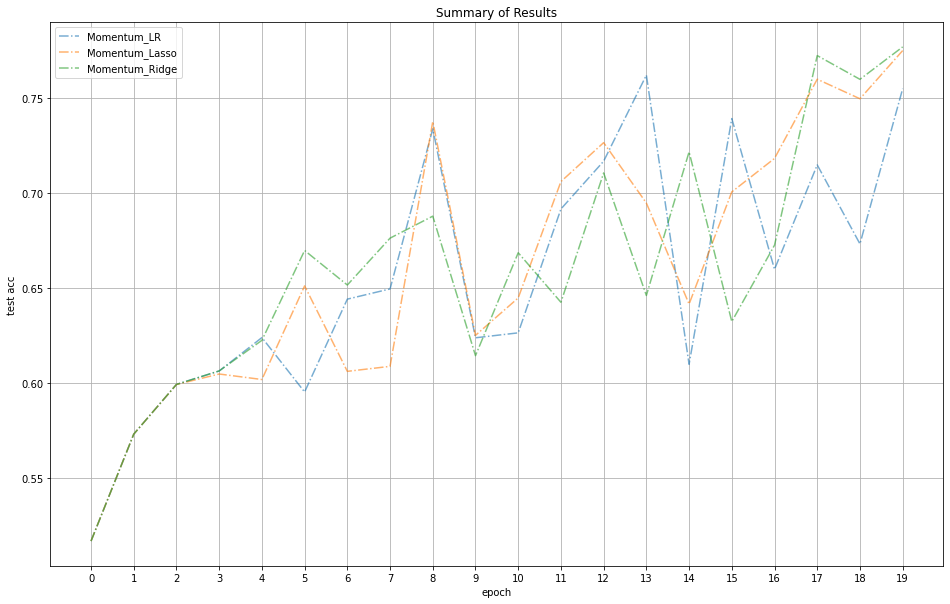

In [129]:
record_list = [record_face, record_lasso_face, record_ridge_face]

record_graph(record_list, 'test_acc_epoch')
# plt.savefig("small_test.jpg")

In [130]:
auc_LR = test_auc(beta_face, test_label, test_img_arr)
auc_Lasso = test_auc(beta_lasso_face, test_label, test_img_arr)
auc_Ridge = test_auc(beta_ridge_face, test_label, test_img_arr)

print(f'Test ROC-AUC w/o regularization: {auc_LR:.5f}')
print(f'Test ROC-AUC with LASSO: {auc_Lasso:.5f}')
print(f'Test ROC-AUC with Ridge: {auc_Ridge:.5f}')

Test ROC-AUC w/o regularization: 0.84319
Test ROC-AUC with LASSO: 0.86580
Test ROC-AUC with Ridge: 0.84769
